# Homework 2: Simple Spread Trading
##### Name: Anand Nakhate
##### Student ID: 12446907
##### Date: 23 January 2025
##### ETFS: 7. GII IGF

In this report, we present a quantitative study of a daily spread‐reversion strategy on two highly correlated infrastructure ETFs, with risk controls and factor regressions. Despite the well‐established mean‐reversion premise in pairs trading, our findings indicate persistent underperformance over 2023–2024, attributable to shifting market conditions and inadvertent factor exposures. Fama–French regressions reveal a significantly negative alpha, underscoring hidden tilts toward value and market neutrality that proved unprofitable in the prevailing macro environment. Further analysis highlights minimal impact from stop‐loss parameters and negative performance correlations to volatility levels (SVOL). These results emphasize the need for volatility‐adaptive thresholds, dynamic factor hedging, and out‐of‐sample validation to ensure resilient, real‐world performance.

#### Introduction:
Global infrastructure ETFs like GII and IGF often exhibit stable co‐movement, making them prime candidates for spread‐based mean‐reversion strategies. Yet recent market evolutions—ranging from rate‐hike cycles to geopolitical shifts—have tested long‐held assumptions about short‐term reversion and stationarity. To scrutinize these dynamics, we built a systematic long–short framework, applying daily thresholds, stop‐loss mechanisms, and transaction cost considerations. In parallel, we probed the strategy’s factor loadings via Fama–French regressions, unveiling a negative alpha tied to incidental value biases. Recognizing that volatility regimes can disrupt correlation patterns, we integrated SVOL (a volatility proxy) to gauge profitability under varying market stress. Our findings offer crucial insights for asset managers and trading desks balancing alpha‐seeking ambitions with risk‐aware execution in real‐time markets.

ETF Overviews
- - GII (Global Infrastructure ETF):
- Invests in essential infrastructure sectors like utilities, transportation, and energy globally, providing broad market coverage.
- Focuses on companies with consistent cash flows, offering reliable dividends and lower volatility.
- Emphasizes investments in sustainable and resilient infrastructure projects, aligning with global green initiatives.
- - IGF (iShares Global Infrastructure ETF)
- Tracks a wide range of global infrastructure companies, including telecommunications and renewable energy.
- Targets firms involved in expanding digital and green infrastructure, positioning for long-term growth.
- Provides exposure across multiple regions, mitigating region-specific risks and capturing international opportunities.

Data Period - Dec 2022 – Nov 2024
- Rising Interest Rates increased borrowing costs for infrastructure projects.
- Post-Pandemic Recovery boosted infrastructure spending and demand.
- Inflation Stabilization eased cost pressures.
- High Market Volatility created trading opportunities for spread strategies.
- Debt Market Fluctuations influenced infrastructure project financing
- Ukraine Conflict disrupted energy supplies and increased energy prices
- US-China Tensions affected global supply chains and investment flows

Effects:
- The period from December 2022 to November 2024 was pivotal for global infrastructure ETFs like GII and IGF. 
- GII leveraged sustainability trends and global diversification to maintain stability, whereas IGF capitalized on digital infrastructure growth and energy market dynamics.
- These factors collectively influenced the performance and strategic positioning of both ETFs.

In [11]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [ ]:
fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False).head()

Removing old file /Users/anandtheerthanakhate/quandl_data_table_downloads/QUOTEMEDIA/PRICES_20250124.zip size 1231749120


In [ ]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices.shape

In [8]:
def process_Fama_French_factors_data(file_path, start_date, end_date):
    FF = pd.read_csv(file_path, skiprows=3).rename(columns={"Unnamed: 0": "date"})
    FF['date'] = pd.to_datetime(FF['date'], format='%Y%m%d') 
    FF.set_index("date", inplace=True)
    FF = FF.loc[start_date: end_date]
    return FF

In [9]:
def process_ticker_data(prices, ticker, start_date, end_date, window):
    df = prices[(prices["ticker"] == ticker)].set_index("date", drop=True).sort_index()
    df = df[["adj_close", "adj_volume"]].rename(columns={"adj_close": "Price", "adj_volume": "Vol"})
    df["DollarVol"] = df["Price"] * df["Vol"]
    df["RollingMed"] = df["DollarVol"].rolling(window=window).median()
    df = df.loc[start_date: end_date]
    return df

In [15]:
START_DATE = "2022-12-02"
END_DATE =  "2024-11-15"
WINDOW = 15
FF_FILE_PATH = "F-F_Research_Data_5_Factors_2x3_daily.csv"

In [21]:
# SVOL Data
SVOL = process_ticker_data(prices, "SVOL", START_DATE, END_DATE, WINDOW)
display(SVOL)

,Price,Vol,DollarVol,RollingMed
date,,,,
2022-12-02,22.0644,109025.0,2405571.21,1505245.95
2022-12-05,22.0000,54825.0,1206150.00,1505245.95
2022-12-06,21.7700,72349.0,1575037.73,1519976.64
2022-12-07,21.7400,35010.0,761117.40,1505245.95
2022-12-08,21.9200,37259.0,816717.28,1284178.38
...,...,...,...,...
2024-11-11,21.9100,766604.0,16796293.64,19832896.98
2024-11-12,21.9000,726001.0,15899421.90,19832896.98
2024-11-13,21.9300,662952.0,14538537.36,18143125.10


In [12]:
# GII Data
GII = process_ticker_data(prices, "GII", START_DATE, END_DATE, WINDOW)
display(GII)

,Price,Vol,DollarVol,RollingMed
date,,,,
2022-12-02,52.763781,5084.0,2.682511e+05,1.072044e+06
2022-12-05,52.089422,32806.0,1.708846e+06,1.142442e+06
2022-12-06,52.118323,30036.0,1.565426e+06,1.142442e+06
2022-12-07,52.002718,25413.0,1.321545e+06,1.279238e+06
2022-12-08,52.310997,92441.0,4.835681e+06,1.279238e+06
...,...,...,...,...
2024-11-11,61.760000,42171.0,2.604481e+06,3.438153e+06
2024-11-12,60.910000,94909.0,5.780907e+06,3.851922e+06
2024-11-13,60.570000,20192.0,1.223029e+06,3.438153e+06


In [13]:
# IGF Data
IGF = process_ticker_data(prices, "IGF", START_DATE, END_DATE, WINDOW)
display(IGF)

,Price,Vol,DollarVol,RollingMed
date,,,,
2022-12-02,44.978556,460478.0,2.071164e+07,1.720062e+07
2022-12-05,44.282818,965678.0,4.276294e+07,1.720062e+07
2022-12-06,44.235808,496605.0,2.196772e+07,1.743691e+07
2022-12-07,44.264014,452291.0,2.002022e+07,1.744622e+07
2022-12-08,44.517865,448038.0,1.994569e+07,1.803252e+07
...,...,...,...,...
2024-11-11,54.280000,171864.0,9.328778e+06,1.948938e+07
2024-11-12,53.540000,740120.0,3.962602e+07,1.948938e+07
2024-11-13,53.330000,254164.0,1.355457e+07,1.948938e+07


In [16]:
# Fama French 5 Factor Model Data
FF = process_Fama_French_factors_data(FF_FILE_PATH, START_DATE, END_DATE)
display(FF)

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2022-12-02,-0.08,0.84,-0.55,-0.41,0.32,0.016
2022-12-05,-2.02,-0.54,-0.52,0.88,0.97,0.016
2022-12-06,-1.51,-0.02,1.15,0.81,0.71,0.016
2022-12-07,-0.24,-0.17,-0.34,0.09,-0.21,0.016
2022-12-08,0.76,-0.09,-1.22,-0.57,-0.64,0.016
...,...,...,...,...,...,...
2024-11-11,0.33,1.14,0.85,-0.93,-0.69,0.020
2024-11-12,-0.39,-1.35,0.09,0.67,0.44,0.020
2024-11-13,-0.12,-0.98,0.13,0.34,0.12,0.020


In [17]:
def combine_ticker_data(df1, df2, ticker1, ticker2):
    df1_prefixed = df1.rename(columns=lambda col: f"{ticker1}_{col}")
    df2_prefixed = df2.rename(columns=lambda col: f"{ticker2}_{col}")
    combined_df = pd.concat([df1_prefixed, df2_prefixed], axis=1)
    combined_df.dropna(inplace=True)
    combined_df["N_t"] = combined_df[[f"{ticker1}_RollingMed", f"{ticker1}_RollingMed"]].min(axis=1)
    return combined_df

In [18]:
df = combine_ticker_data(GII, IGF, "GII", "IGF")
display(df)

,GII_Price,GII_Vol,GII_DollarVol,GII_RollingMed,IGF_Price,IGF_Vol,IGF_DollarVol,IGF_RollingMed,N_t
date,,,,,,,,,
2022-12-02,52.763781,5084.0,2.682511e+05,1.072044e+06,44.978556,460478.0,2.071164e+07,1.720062e+07,1.072044e+06
2022-12-05,52.089422,32806.0,1.708846e+06,1.142442e+06,44.282818,965678.0,4.276294e+07,1.720062e+07,1.142442e+06
2022-12-06,52.118323,30036.0,1.565426e+06,1.142442e+06,44.235808,496605.0,2.196772e+07,1.743691e+07,1.142442e+06
2022-12-07,52.002718,25413.0,1.321545e+06,1.279238e+06,44.264014,452291.0,2.002022e+07,1.744622e+07,1.279238e+06
2022-12-08,52.310997,92441.0,4.835681e+06,1.279238e+06,44.517865,448038.0,1.994569e+07,1.803252e+07,1.279238e+06
...,...,...,...,...,...,...,...,...,...
2024-11-11,61.760000,42171.0,2.604481e+06,3.438153e+06,54.280000,171864.0,9.328778e+06,1.948938e+07,3.438153e+06
2024-11-12,60.910000,94909.0,5.780907e+06,3.851922e+06,53.540000,740120.0,3.962602e+07,1.948938e+07,3.851922e+06
2024-11-13,60.570000,20192.0,1.223029e+06,3.438153e+06,53.330000,254164.0,1.355457e+07,1.948938e+07,3.438153e+06


In [19]:
print("Descriptive Statistics for DF (X and Y)")
df.describe()

Descriptive Statistics for DF (X and Y)


,GII_Price,GII_Vol,GII_DollarVol,GII_RollingMed,IGF_Price,IGF_Vol,IGF_DollarVol,IGF_RollingMed,N_t
count,492.000000,492.000000,4.920000e+02,4.920000e+02,492.000000,4.920000e+02,4.920000e+02,4.920000e+02,4.920000e+02
mean,53.518260,35367.136179,1.893769e+06,1.196845e+06,46.499263,4.786760e+05,2.217982e+07,1.625933e+07,1.196845e+06
std,3.653838,46957.988224,2.497949e+06,6.838919e+05,3.461405,7.227900e+05,3.427821e+07,5.057181e+06,6.838919e+05
min,45.857721,2602.000000,1.374419e+05,3.235189e+05,39.706224,1.002120e+05,4.648840e+06,7.954333e+06,3.235189e+05
25%,51.244609,11397.000000,6.114756e+05,7.197773e+05,44.344080,2.380220e+05,1.108852e+07,1.222522e+07,7.197773e+05
50%,52.758690,20063.000000,1.062200e+06,9.698457e+05,45.582152,3.414240e+05,1.577306e+07,1.626475e+07,9.698457e+05
75%,55.187500,38340.500000,2.047198e+06,1.429641e+06,48.307500,5.094325e+05,2.327036e+07,1.945584e+07,1.429641e+06
max,62.940000,552101.000000,2.764168e+07,3.851922e+06,55.320000,8.948886e+06,4.745594e+08,3.857639e+07,3.851922e+06


In [22]:
print("Descriptive Statistics for SVOL")
SVOL.describe()

Descriptive Statistics for SVOL


,Price,Vol,DollarVol,RollingMed
count,492.000000,4.920000e+02,4.920000e+02,4.920000e+02
mean,22.406483,5.456500e+05,1.218162e+07,1.085834e+07
std,0.494095,4.463267e+05,9.575965e+06,6.253368e+06
min,20.050000,3.438500e+04,7.495930e+05,1.090205e+06
25%,22.060000,2.609345e+05,5.901461e+06,4.929190e+06
50%,22.550000,4.650305e+05,1.058095e+07,9.641370e+06
75%,22.780000,7.333330e+05,1.641177e+07,1.552950e+07
max,23.180000,5.432322e+06,1.089181e+08,2.815194e+07


In [23]:
print("Descriptive Statistics for Fama-French factors")
FF.describe()

Descriptive Statistics for Fama-French factors


,Mkt-RF,SMB,HML,RMW,CMA,RF
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,0.063638,-0.026402,-0.022927,0.015427,-0.038394,0.019685
std,0.867235,0.775506,0.761373,0.508793,0.481453,0.002041
min,-3.020000,-2.520000,-3.520000,-1.530000,-1.650000,0.016000
25%,-0.412500,-0.522500,-0.540000,-0.310000,-0.340000,0.018000
50%,0.045000,-0.055000,-0.055000,0.020000,-0.050000,0.021000
75%,0.640000,0.362500,0.465000,0.360000,0.232500,0.021000
max,2.920000,4.210000,3.600000,1.480000,1.470000,0.022000


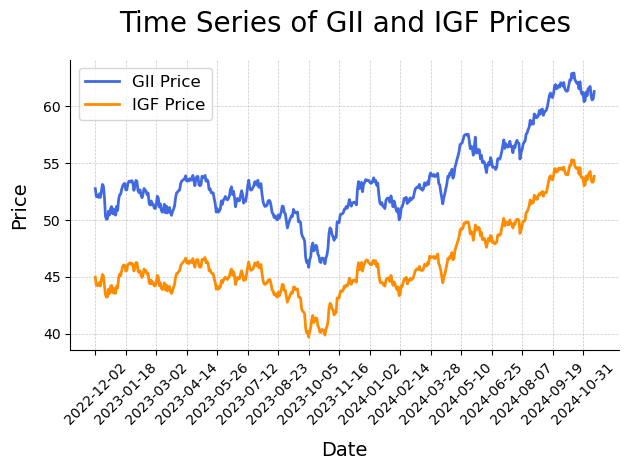

In [24]:
plt.plot(df.index, df['GII_Price'], label='GII Price', color='royalblue', linewidth=2)
plt.plot(df.index, df['IGF_Price'], label='IGF Price', color='darkorange', linewidth=2)
plt.title('Time Series of GII and IGF Prices', fontsize=20, pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Price', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True)
plt.xticks(df.index[::30], rotation=45, fontsize=10)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

- Both ETFs trended upward post‐mid‐2023, mirroring global infrastructure’s rebound from pandemic lows.
- Noticeable dips (e.g., mid‐2023) often align with rate‐hike announcements, underscoring sensitivity to borrowing‐cost shocks.
- GII’s price stability reflects heavier weighting in core utilities/energy
- IGF’s faster climbs capture digital & green infrastructure momentum.
- Ukraine conflict–driven energy price spikes buoyed both funds
- US‐China tensions briefly cooled enthusiasm for global expansion.

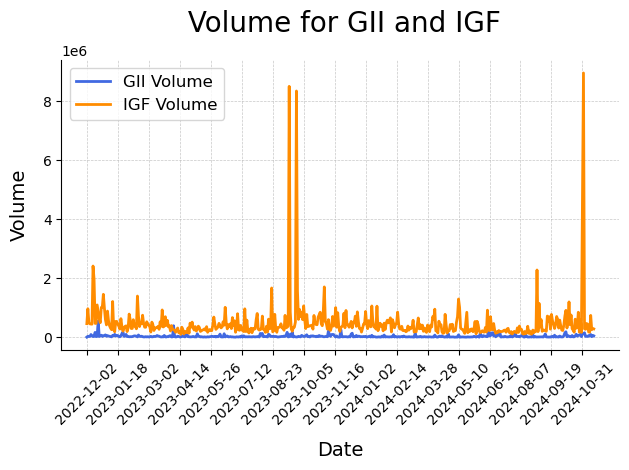

In [25]:
plt.plot(df.index, df['GII_Vol'], label='GII Volume', color='royalblue', linewidth=2)
plt.plot(df.index, df['IGF_Vol'], label='IGF Volume', color='darkorange', linewidth=2)
plt.title(' Volume for GII and IGF', fontsize=20, pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Volume', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True)
plt.xticks(df.index[::30], rotation=45, fontsize=10)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

- IGF’s frequent volume spikes suggest greater investor attention and heavier institutional flows.
- Sharp peaks in volume coincide with macro news (e.g., interest‐rate changes) and rebalancing events, fueling short‐term trading.
- Lower volatility in GII’s volume points to a “buy‐and‐hold” investor base focusing on stable dividend payers.
- High volume swings opened arbitrage/spread‐trade possibilities, especially amid inflation or conflict‐related uncertainty.

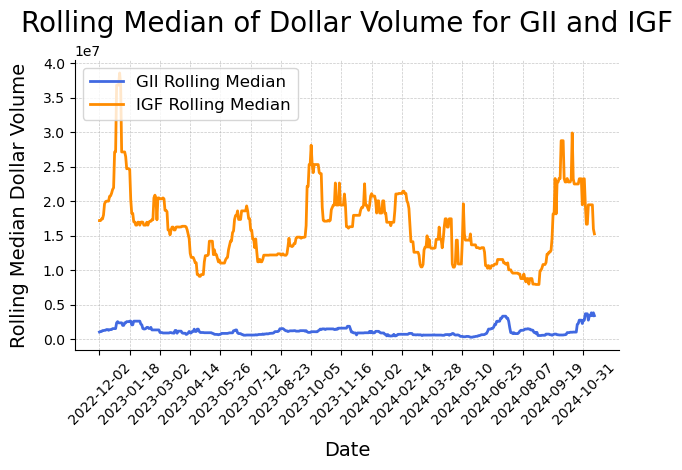

In [26]:
plt.plot(df.index, df['GII_RollingMed'], label='GII Rolling Median', color='royalblue', linewidth=2)
plt.plot(df.index, df['IGF_RollingMed'], label='IGF Rolling Median', color='darkorange', linewidth=2)
plt.title('Rolling Median of Dollar Volume for GII and IGF', fontsize=20, pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Rolling Median Dollar Volume', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True)
plt.xticks(df.index[::30], rotation=45, fontsize=10)
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

- The consistently higher median indicates robust capital rotation in digital/renewable infrastructure plays.
- Spikes often followed government stimulus or infrastructure spending bills, revealing policy as a volume catalyst.
- Modest upticks in GII’s dollar volume suggest growing investor confidence in sustainable infrastructure’s steady returns.
- Fluctuations in both series highlight how quickly infrastructure financing can pivot on changes in rates, inflation, or geopolitical tensions.

In [27]:
df.index = pd.to_datetime(df.index)
SVOL.index = pd.to_datetime(SVOL.index)
FF.index = pd.to_datetime(FF.index)
common_index = df.index.intersection(SVOL.index).intersection(FF.index)
df_main = df.loc[common_index]
df_svol = SVOL.loc[common_index]
df_ff = FF.loc[common_index]

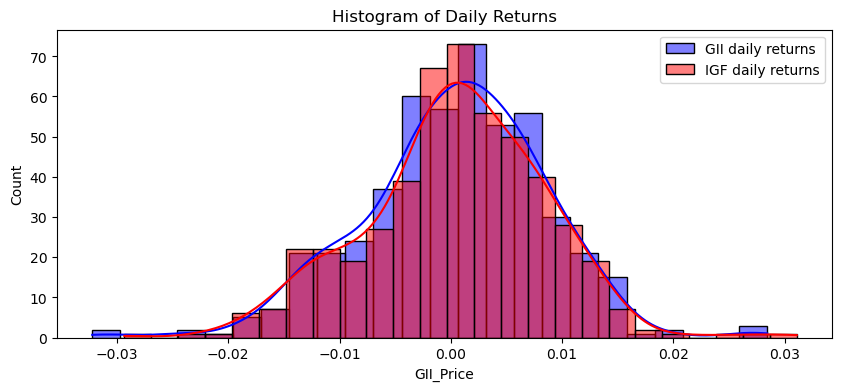

In [28]:
# Distribution of Daily Returns
gii_ret = df_main['GII_Price'].pct_change().dropna()
igf_ret = df_main['IGF_Price'].pct_change().dropna()

plt.figure(figsize=(10,4))
sns.histplot(gii_ret, kde=True, color='blue', label='GII daily returns')
sns.histplot(igf_ret, kde=True, color='red', label='IGF daily returns')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

- Both ETFs cluster around small daily gains/losses, consistent with defensive, income‐oriented assets.
- High Correlation suggests that broad global infrastructure themes dominate day‐to‐day price movements in both funds.
- IGF’s tilt toward tech/renewables adds a touch more upside variance
- GII’s traditional utilities angle shows extreme swings.

In [29]:
print(df_main[['GII_Price', 'IGF_Price']].describe())

        GII_Price   IGF_Price
count  492.000000  492.000000
mean    53.518260   46.499263
std      3.653838    3.461405
min     45.857721   39.706224
25%     51.244609   44.344080
50%     52.758690   45.582152
75%     55.187500   48.307500
max     62.940000   55.320000


In [30]:
df_main['GII_Return'] = df_main['GII_Price'].pct_change()
df_main['IGF_Return'] = df_main['IGF_Price'].pct_change()

df_main.dropna(subset=['GII_Return','IGF_Return'], inplace=True)
corr_daily = df_main[['GII_Return','IGF_Return']].corr().iloc[0,1]
print(f"Correlation of daily returns: {corr_daily:.4f}")

Correlation of daily returns: 0.9752


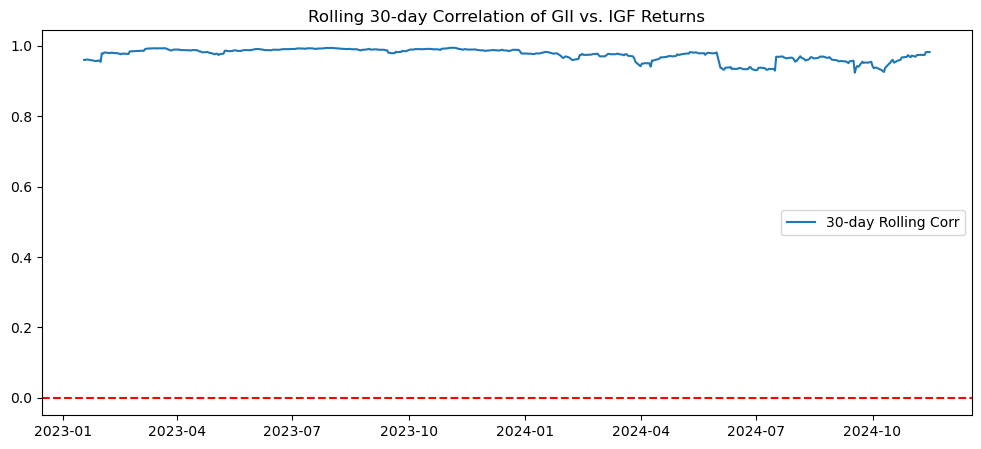

In [31]:
df_main['RollingCorr_30'] = df_main['GII_Return'].rolling(30).corr(df_main['IGF_Return'])
plt.figure(figsize=(12,5))
plt.title('Rolling 30-day Correlation of GII vs. IGF Returns')
plt.plot(df_main.index, df_main['RollingCorr_30'], label='30-day Rolling Corr')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

- The correlation remains extremely high (~0.97 to 0.99) throughout most of the period.
- High correlation between two instruments is often a foundation for spread trading. A stable correlation implies a consistent relationship (co-movement), setting the stage for potential mean reversion if they temporarily diverge.
- We see minor dips (e.g., early 2023 or mid-2024) never drop below 0.95.
- GII and IGF likely share very similar underlying exposures—global infrastructure equities sensitive to interest rates, macroeconomic cycles, and large public spending announcements.
- Even during periods of monetary policy shifts (e.g., potential Fed rate hikes) or geopolitical events, these funds moved largely in tandem, indicating no major structural divergence in their underlying holdings.
- With such a high correlation, we expect very tight spreads—meaning trades must be precise and well-timed to exploit small divergences, and transaction costs become critical.

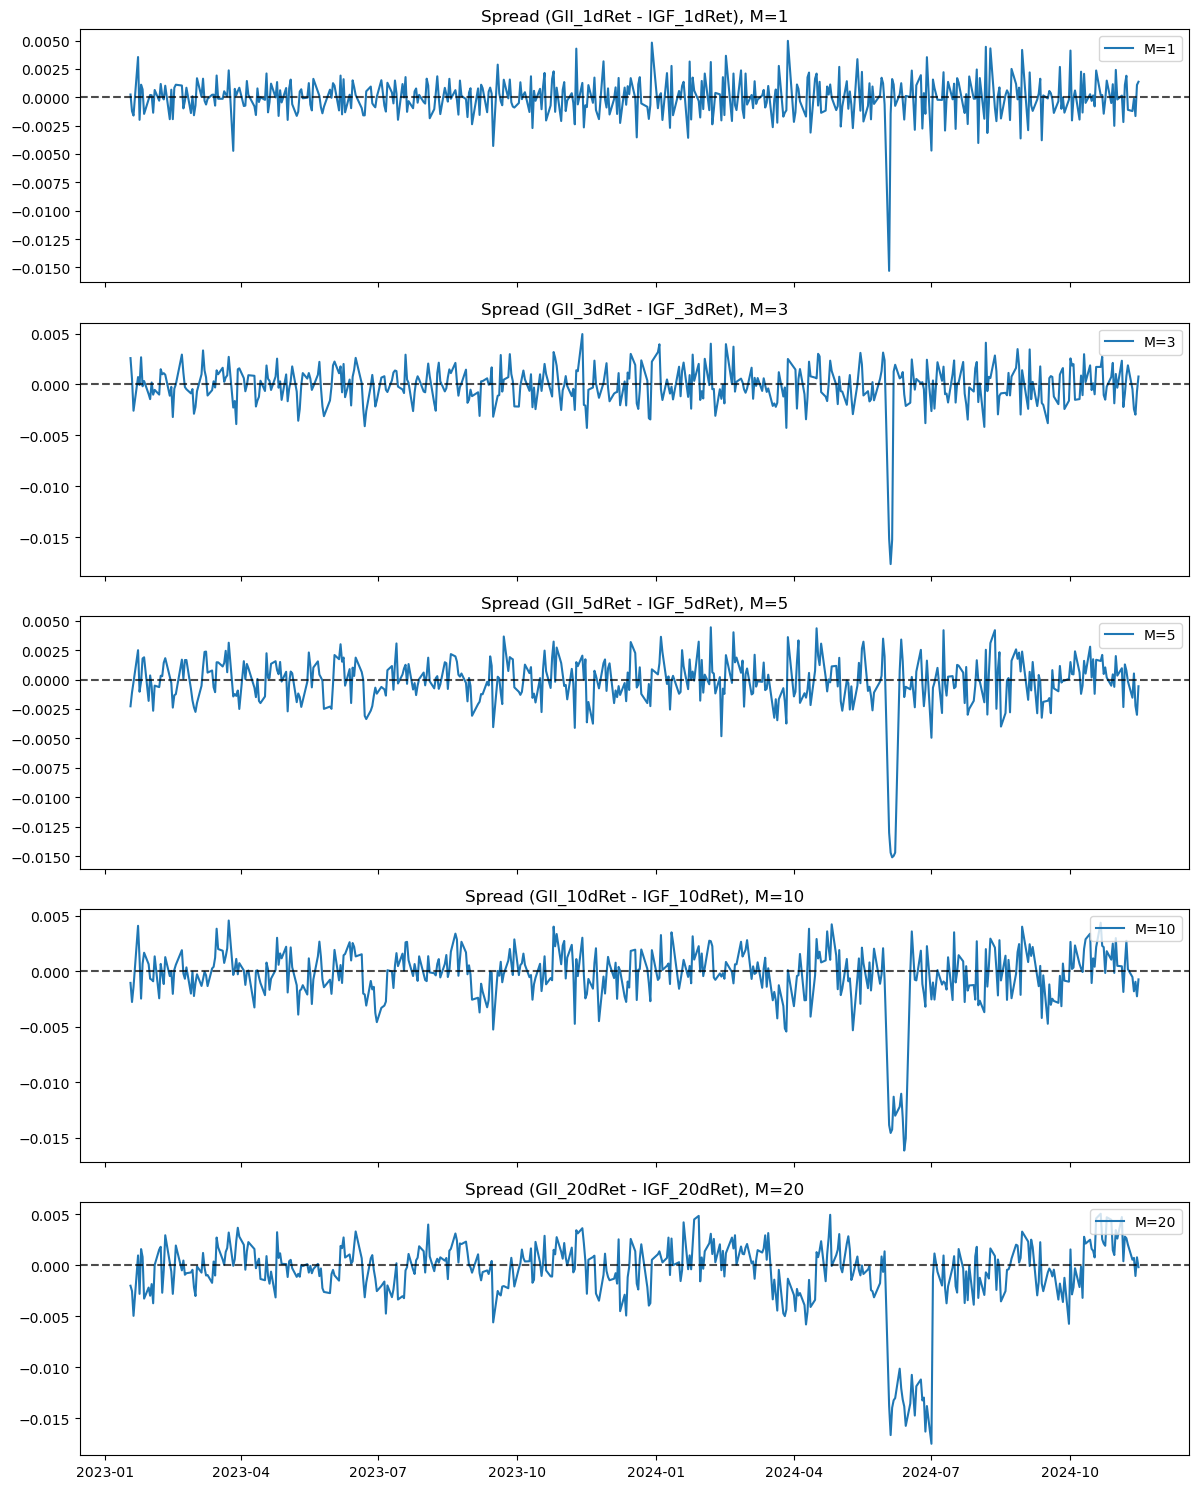

In [32]:
M_values = [1, 3, 5, 10, 20]
for M in M_values:
    df_main[f'GII_{M}dRet'] = df_main['GII_Price'].pct_change(M)
    df_main[f'IGF_{M}dRet'] = df_main['IGF_Price'].pct_change(M)
    df_main[f'SPREAD_{M}'] = df_main[f'GII_{M}dRet'] - df_main[f'IGF_{M}dRet']

df_main.dropna(inplace=True)

fig, axes = plt.subplots(len(M_values), 1, figsize=(12, 3*len(M_values)), sharex=True)
for i, M in enumerate(M_values):
    ax = axes[i]
    ax.plot(df_main.index, df_main[f'SPREAD_{M}'], label=f'M={M}')
    ax.axhline(0, color='black', linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    ax.set_title(f'Spread (GII_{M}dRet - IGF_{M}dRet), M={M}')
plt.tight_layout()
plt.show()

- Calculated SPREAD for different M's and  Plotted each spread over time on separate charts.
- Different lookback windows capture divergences over different time scales. Shorter windows show more frequent but smaller deviations; longer windows may show more pronounced divergences (but fewer trades).
- This helps us see how often and violently the spread deviates, possibly informing thresholds (g,j) for our strategy.
- Short Horizons (M=1,3): The spread typically oscillates between -0.5% and +0.5%, with occasional dips near -1.5%.
- Medium Horizons (M=5,10): Spreads can reach ~-1.5% more frequently; they’re bigger on average but still rarely exceed ±1–1.5%.
- Long Horizon (M=20): More smoothed but sometimes sees deeper plunges ~2.0% (though rare), possibly reflecting cumulative divergences over a full month.
- Both ETFs track global infrastructure, so day-to-day divergences remain small. Macro events (e.g., rate announcements, commodity price shocks) occasionally cause short-lived spikes.
- The deeper dives might coincide with news specific to infrastructure spending or big political decisions (e.g., US Infrastructure Bill, Chinese infrastructure ramp-up) causing one ETF’s holdings to diverge slightly more than the other’s.
- If we want fewer, larger trades, a 10-day or 20-day lookback might be more suitable, capturing more material divergences. If we prefer frequent, small mean reversions, M=1 or M=3 is viable but demands low transaction costs and agile execution.


Spread M=1: mean=-0.0034%, std=0.1698%, skew=-1.46, kurt=13.76


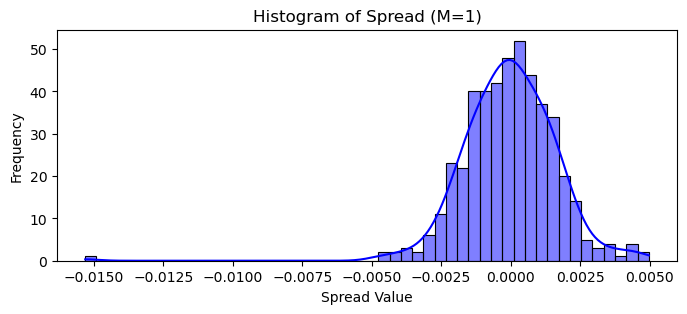


Spread M=3: mean=-0.0102%, std=0.2104%, skew=-2.79, kurt=20.37


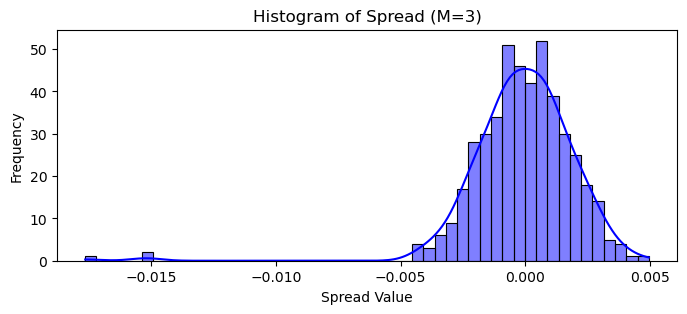


Spread M=5: mean=-0.0181%, std=0.2242%, skew=-2.75, kurt=16.41


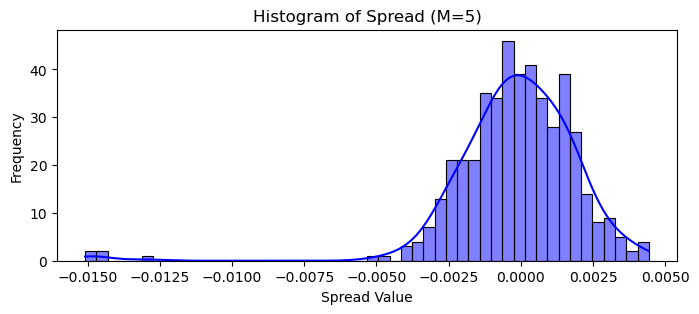


Spread M=10: mean=-0.0339%, std=0.2699%, skew=-2.52, kurt=11.07


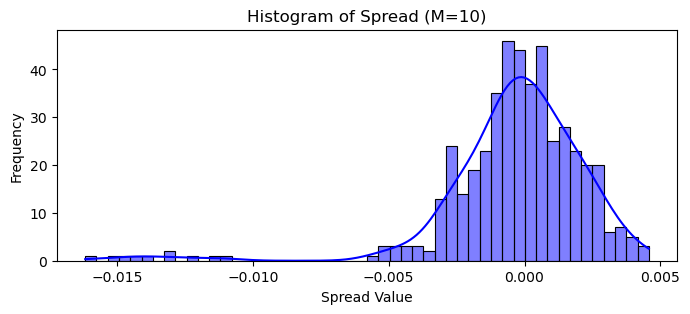


Spread M=20: mean=-0.0708%, std=0.3419%, skew=-2.33, kurt=7.38


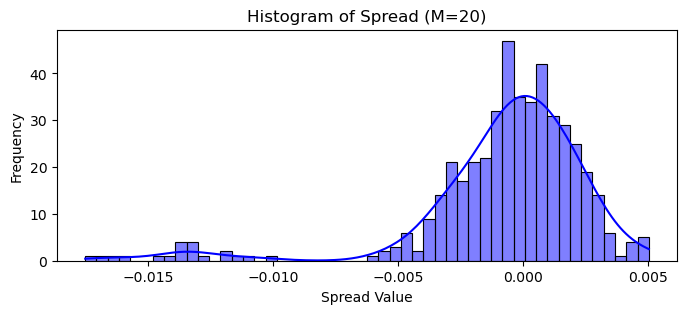

In [33]:
for M in M_values:
    spread_col = f'SPREAD_{M}'
    spread_data = df_main[spread_col].dropna()
    
    mean_ = spread_data.mean()
    std_ = spread_data.std()
    skew_ = spread_data.skew()
    kurt_ = spread_data.kurtosis()
    
    print(f"\nSpread M={M}: mean={mean_:.4%}, std={std_:.4%}, skew={skew_:.2f}, kurt={kurt_:.2f}")
    
    plt.figure(figsize=(8,3))
    sns.histplot(spread_data, kde=True, bins=50, color='blue')
    plt.title(f"Histogram of Spread (M={M})")
    plt.xlabel('Spread Value')
    plt.ylabel('Frequency')
    plt.show()

- For each M, we created histograms and computed descriptive stats (mean, std, skew, kurtosis) for spread and displayed how the spread is distributed
- Understanding the shape of the spread distribution helps gauge tail risk, frequency of large moves, and the average or median deviation.
- Means are slightly negative (e.g., -0.0034% for M=1, down to -0.07% for M=20), suggesting a mild bias toward negative spread values.
- Std ranges from ~0.17% (M=1) up to ~0.34% (M=20).
- Skew is negative (-1.4 to -2.8), meaning larger left-tail events. Negative skew suggests that shorting GII vs. longing IGF might face sharper drawdowns if GII collapses faster than IGF.
- Kurtosis is high (up to 20.4), implying fatter tails than a normal distribution.
- Possibly indicates that, during risk-off episodes or certain market stress periods, one fund underperforms more sharply than the other. This could correlate with a flight to safer assets if IGF or GII has a different weight in more defensive stocks.
- Rare but severe outliers can occur, maybe triggered by major shocks/ events
-  A robust stop-loss is crucial. The relatively small typical daily spread (±0.3–0.5%) means we must keep thresholds modest. Large thresholds (>1%) will rarely trigger trades.

In [34]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.6f}")
    for key, value in result[4].items():
        print(f'Crit. Values: {key}, {value:.4f}')

for M in M_values:
    print(f"\n==== ADF Test for Spread_{M} ====")
    adf_test(df_main[f'SPREAD_{M}'])


==== ADF Test for Spread_1 ====
ADF Statistic: -15.2774
p-value: 0.000000
Crit. Values: 1%, -3.4447
Crit. Values: 5%, -2.8679
Crit. Values: 10%, -2.5701

==== ADF Test for Spread_3 ====
ADF Statistic: -5.3023
p-value: 0.000005
Crit. Values: 1%, -3.4451
Crit. Values: 5%, -2.8680
Crit. Values: 10%, -2.5702

==== ADF Test for Spread_5 ====
ADF Statistic: -4.8055
p-value: 0.000053
Crit. Values: 1%, -3.4451
Crit. Values: 5%, -2.8680
Crit. Values: 10%, -2.5702

==== ADF Test for Spread_10 ====
ADF Statistic: -3.9565
p-value: 0.001656
Crit. Values: 1%, -3.4451
Crit. Values: 5%, -2.8680
Crit. Values: 10%, -2.5702

==== ADF Test for Spread_20 ====
ADF Statistic: -3.7431
p-value: 0.003547
Crit. Values: 1%, -3.4447
Crit. Values: 5%, -2.8679
Crit. Values: 10%, -2.5701


- We conduct ADF tests on each spread to see if it was stationary (p-value < 0.05 means we reject non-stationarity).
- Pairs trading relies heavily on the notion of mean-reverting or at least covariance-stationary spreads.
- All M-day spreads have ADF p-values near 0.0, strongly rejecting the null hypothesis of a unit root.
- Even for M=20, the test suggests the series is still stationary.
- The stationarity assures that when the spread diverges, there is an inherent tendency to revert, which is exactly what contrarian trades exploit.
- A stable, stationary spread from Jan 2023–Nov 2024 indicates no large structural break in that period—though future big macro changes could alter the relationship.

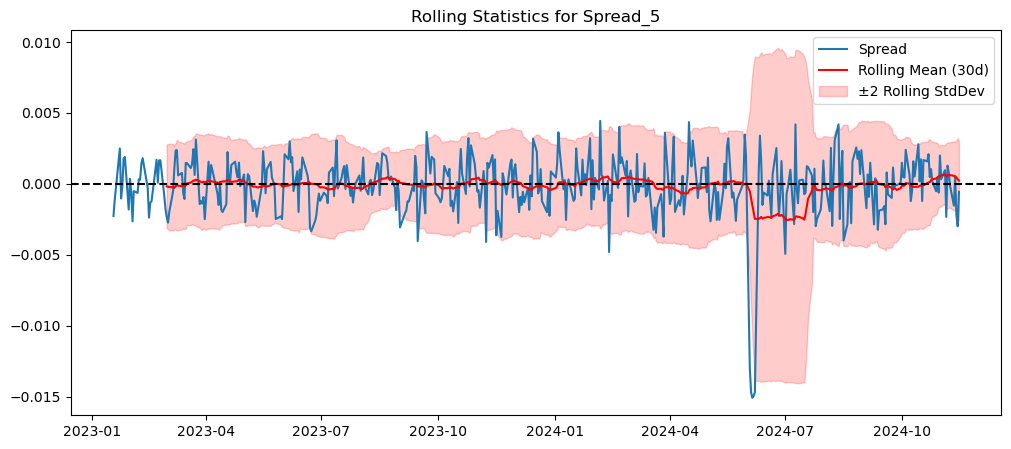

In [35]:
chosen_M = 5  
df_main[f'SPREAD_{chosen_M}_ROLL_MEAN'] = df_main[f'SPREAD_{chosen_M}'].rolling(30).mean()
df_main[f'SPREAD_{chosen_M}_ROLL_STD'] = df_main[f'SPREAD_{chosen_M}'].rolling(30).std()

plt.figure(figsize=(12,5))
plt.plot(df_main.index, df_main[f'SPREAD_{chosen_M}'], label='Spread')
plt.plot(df_main.index, df_main[f'SPREAD_{chosen_M}_ROLL_MEAN'], color='red', label='Rolling Mean (30d)')
plt.fill_between(df_main.index,
                 df_main[f'SPREAD_{chosen_M}_ROLL_MEAN'] - 2*df_main[f'SPREAD_{chosen_M}_ROLL_STD'],
                 df_main[f'SPREAD_{chosen_M}_ROLL_MEAN'] + 2*df_main[f'SPREAD_{chosen_M}_ROLL_STD'],
                 color='red', alpha=0.2, label='±2 Rolling StdDev')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"Rolling Statistics for Spread_{chosen_M}")
plt.legend()
plt.show()

- Even a stable correlation can experience shifting volatility regimes. If volatility spikes, threshold-based trades might trigger more frequently.
- If the rolling mean drifts away from zero or the std widens significantly, it could indicate a changing market structure.
- The rolling mean mostly hovers near zero, occasionally dipping negative.
- The ±2 std band is typically around ±0.3–0.6%, widening significantly during a few episodes (notably mid-2024).
- The big band expansions might correspond to macro events—e.g., a sudden credit shock or large new infrastructure spending announcements that impacted one ETF more.
- A short-lived spike that returns promptly to the band suggests a profitable reversion opportunity. A sustained shift might mean the spread is “breaking” its old correlation assumption.

In [36]:
def get_spread_top_percentiles(M = 5):
    spread = df_main[f'SPREAD_{M}'].abs().dropna()
    p95 = spread.quantile(0.95)
    p99 = spread.quantile(0.99)
    print(f"95th percentile of |z_t| at M = {M} = {p95:.4%}, 99th = {p99:.4%}")

get_spread_top_percentiles(M=1)
get_spread_top_percentiles(M=3)
get_spread_top_percentiles(M=5)
get_spread_top_percentiles(M=10)
get_spread_top_percentiles(M=20)

95th percentile of |z_t| at M = 1 = 0.3117%, 99th = 0.4547%
95th percentile of |z_t| at M = 3 = 0.3316%, 99th = 0.4270%
95th percentile of |z_t| at M = 5 = 0.3391%, 99th = 0.8085%
95th percentile of |z_t| at M = 10 = 0.4101%, 99th = 1.3480%
95th percentile of |z_t| at M = 20 = 0.5026%, 99th = 1.4273%


- Pair traders typically set an entry threshold at or above the 95th percentile to capture more extreme dislocations.
- Knowing how often we might trigger a trade helps balance strategy frequency vs. magnitude of potential returns.
- 95th percentile ranges from ~0.31% (M=1) to ~0.50% (M=20).
- The 99th percentile can shoot up to 0.8–1.4% for M=5, 10 and 20.
- The max absolute spread is around 1.5–1.8% in extreme cases (once or twice in the sample).
- Since the 95th percentile for M=5 is ~0.34%, we might set g ~ 0.35–0.4% to target rare events. If we want more trades, sweet g ~0.25–0.3%.
- A threshold near the 95th percentile means trades are relatively infrequent but potentially more profitable if they revert. A threshold near the 80th percentile (~0.2–0.25%) yields more frequent signals but possibly more false positives.
- Most divergences remain small, indicating GII and IGF track nearly identical factors. Only under certain stress or surprise events (e.g., sudden Fed pivot, major infrastructure news) does the spread breach 0.5–1%.

In [37]:
summary_df = []
for M in M_values:
    spread_col = f'SPREAD_{M}'
    # absolute spread
    abs_spread = df_main[spread_col].abs().dropna()
    stats_dict = {
        'M': M,
        'MaxAbsSpread': abs_spread.max(),
        'MeanAbsSpread': abs_spread.mean(),
        '95PercAbsSpread': abs_spread.quantile(0.95)
    }
    summary_df.append(stats_dict)

summary_df = pd.DataFrame(summary_df)
display(summary_df)

,M,MaxAbsSpread,MeanAbsSpread,95PercAbsSpread
0,1,0.015309,0.001240,0.003117
1,3,0.017645,0.001442,0.003316
2,5,0.015089,0.001491,0.003391
3,10,0.016176,0.001735,0.004101
4,20,0.017504,0.002154,0.005026


- The GII–IGF pair exhibits a very high correlation (~0.975+). ADF tests confirm stationarity, so a spread-reversion framework is theoretically sound. This is exactly the scenario many academic pairs-trading models thrive on—a stable relationship with small but persistent noise.
- Spreads mostly stay within ±0.3–0.5%. One or two major spikes to ±1.5%. We must use relatively small thresholds (e.g., 0.2–0.5%) for entering trades. A 2% threshold is far too large given the data distribution.
- Large negative shocks are possible. High kurtosis indicates fat tails. We miust incorporate robust stop-losses. Being on the wrong side of a tail event without discipline can lead to outsized losses.
- Shorter M=1 or M=3: More frequent signals, smaller typical spreads. Possibly higher trading costs. Medium M=5 or M=10: Balanced approach; still modest daily spreads but enough movement for trades. Longer M=20: Fewer trades, but those divergences might be more substantial.
- Global infrastructure ETFs are sensitive to interest rates and government spending decisions. Spikes in the spread often align with events like Federal Reserve announcements or major infrastructure policy news.
- Geopolitical factors (e.g., trade tensions, supply chain issues) can also cause brief dislocations if one ETF is more exposed to a particular region.
- Initial Parameter selection based on the above: -
  - g ~ 0.20–0.40% for M=5, stepping up to ~0.4–0.6% if M=10 or M=20.
  - j ~ half of g.
  - s ~ 3–5% of notional to protect from rare but severe negative moves.

## Methodology 
- We use two highly correlated global infrastructure ETFs, GII and IGF
- For a chosen lookback (e.g., 5, 10, 20 days), we compute the difference between the cumulative returns of GII and IGF over that M-day window. This difference is the spread.
- Entry: If ∣spread∣ > g, we open a contrarian position: short the ETF whose  M-day return is higher and goes long the one whose M-day return is lower, anticipating mean reversion.
- Exit: If ∣spread∣<j, we close any open spread position.
- If the position’s mark‐to‐market loss exceeds this threshold, we close the position and take no new positions until the next calendar month.
- We allocate Nt/100 dollars on each side (long/short), where Nt is rolling median 15-day dollar volume for the less liquid ETF.
- Costs & Capital: Trading cost is proportional to gross notional.
- Capital =2×max2×max(Nt/100)
- Daily PnL is scaled by K to compute returns on capital.
- Performance Metrics: We track daily PnL, cumulative PnL, Sharpe ratio, Sortino ratio, max drawdown, Calmar ratio, trade statistics (win/loss rates, average win/loss, etc.)

In [38]:
import pandas as pd
import numpy as np

class SpreadReversionStrategy:
    def __init__(
        self,
        df_main,
        M=20,             
        j=0.0025,         
        g=0.005,          
        s=0.04,           
        zeta=0.00001,     
        start_date='2023-01-02',
        end_date='2024-11-15',
        debug=False
    ):
        self.df = df_main.copy()
        self.M = M
        self.j = j
        self.g = g
        self.s = s
        self.zeta = zeta
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.debug = debug
        
        self.x_col = 'GII_Price'  
        self.y_col = 'IGF_Price'  
        self.spread_col = f'SPREAD_{self.M}'  
        if 'Date' not in self.df.columns:
            self.df['Date'] = self.df.index
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        mask = (self.df['Date'] >= self.start_date) & (self.df['Date'] <= self.end_date)
        self.df = self.df.loc[mask].copy()
        self.capital = 2.0 * self.df['N_t'].max()
        self.df['Position']       = 0.0   
        self.df['Shares_X']       = 0.0
        self.df['Shares_Y']       = 0.0
        self.df['DailyPnL']       = 0.0
        self.df['CumulativePnL']  = 0.0
        self.df['StopActive']     = False 
        self.metrics = {}
        self.trade_log = []


    def run_backtest(self):

        df = self.df
        
        dates       = df['Date'].values
        price_x_arr = df[self.x_col].values
        price_y_arr = df[self.y_col].values
        spread_arr  = df[self.spread_col].values
        n_t_arr     = df['N_t'].values
        
        position_arr  = np.zeros(len(df))
        shares_x_arr  = np.zeros(len(df))
        shares_y_arr  = np.zeros(len(df))
        daily_pnl_arr = np.zeros(len(df))
        stop_arr      = np.zeros(len(df), dtype=bool)
        
        current_pos    = 0.0   
        shares_x       = 0.0
        shares_y       = 0.0
        entry_value_x  = 0.0
        entry_value_y  = 0.0
        entry_gross    = 0.0
        
        cum_pnl = 0.0
        
        last_stop_month = -1
        last_stop_year  = -1
        
        for i in range(1, len(df)):
            px_change_x = price_x_arr[i] - price_x_arr[i-1]
            px_change_y = price_y_arr[i] - price_y_arr[i-1]
            daily_pnl = shares_x * px_change_x + shares_y * px_change_y
            cum_pnl   += daily_pnl
            
            if current_pos != 0.0:
                curr_val_x = shares_x * price_x_arr[i]
                curr_val_y = shares_y * price_y_arr[i]
                open_pl    = (curr_val_x + curr_val_y) - (entry_value_x + entry_value_y)
                if open_pl < -self.s * entry_gross:
                    if self.debug:
                        print(f"[STOP] {dates[i]}: PnL={open_pl:.2f} < -{self.s*entry_gross:.2f}")
                    
                    exit_gross = abs(curr_val_x) + abs(curr_val_y)
                    cost_exit  = self.zeta * exit_gross
                    daily_pnl -= cost_exit
                    cum_pnl   -= cost_exit

                    self.trade_log.append({
                        'Date': dates[i],
                        'Action': 'STOP_LOSS_EXIT',
                        'Position': current_pos,
                        'PnL': open_pl - cost_exit,
                        'GrossExit': exit_gross
                    })
                    
                    current_pos = 0.0
                    shares_x    = 0.0
                    shares_y    = 0.0
                    entry_gross = 0.0
                    stop_arr[i] = True
                    
                    dts = pd.to_datetime(dates[i])
                    last_stop_month = dts.month
                    last_stop_year  = dts.year
            
            dts = pd.to_datetime(dates[i])
            in_stop_window = (dts.year == last_stop_year) and (dts.month == last_stop_month)
            
            zt    = spread_arr[i]
            abs_zt= abs(zt)
            
            if not in_stop_window:
                if current_pos == 0.0:
                    if abs_zt > self.g:
                        new_pos = -1.0 if zt > 0 else 1.0
                        current_pos = new_pos
                        dollar_each_side = n_t_arr[i]/100.0
                        if new_pos == -1.0:
                            shares_x = -dollar_each_side / price_x_arr[i]
                            shares_y = +dollar_each_side / price_y_arr[i]
                        else:
                            shares_x = +dollar_each_side / price_x_arr[i]
                            shares_y = -dollar_each_side / price_y_arr[i]
                        
                        entry_value_x = shares_x * price_x_arr[i]
                        entry_value_y = shares_y * price_y_arr[i]
                        entry_gross   = abs(entry_value_x) + abs(entry_value_y)
                        
                        cost_entry = self.zeta * entry_gross
                        daily_pnl  -= cost_entry
                        cum_pnl    -= cost_entry
                        
                        self.trade_log.append({
                            'Date': dates[i],
                            'Action': 'OPEN',
                            'Position': current_pos,
                            'GrossCash': entry_gross,
                            'Cost': cost_entry
                        })
                        
                        if self.debug:
                            print(f"{dates[i]} => OPEN pos={new_pos:.0f}, zt={zt:.4f}, cost={cost_entry:.2f}")
                
                else:
                    if abs_zt < self.j:
                        exit_val_x = shares_x * price_x_arr[i]
                        exit_val_y = shares_y * price_y_arr[i]
                        exit_gross = abs(exit_val_x) + abs(exit_val_y)
                        cost_exit = self.zeta * exit_gross
                        daily_pnl -= cost_exit
                        cum_pnl   -= cost_exit
                        open_pl = (exit_val_x + exit_val_y) - (entry_value_x + entry_value_y)
                        self.trade_log.append({
                            'Date': dates[i],
                            'Action': 'CLOSE',
                            'Position': current_pos,
                            'PnL': open_pl - cost_exit,
                            'GrossExit': exit_gross
                        })
                        
                        if self.debug:
                            print(f"{dates[i]} => FLATTEN pos={current_pos:.0f}, zt={zt:.4f}, PnL={open_pl:.2f}, cost={cost_exit:.2f}")
                        
                        current_pos = 0.0
                        shares_x    = 0.0
                        shares_y    = 0.0
                        entry_gross = 0.0
                    else:
                        sign_zt = np.sign(zt)
                        if (sign_zt < 0 and current_pos > 0) or (sign_zt > 0 and current_pos < 0):
                            # Flip
                            exit_val_x = shares_x * price_x_arr[i]
                            exit_val_y = shares_y * price_y_arr[i]
                            exit_gross = abs(exit_val_x) + abs(exit_val_y)
                            cost_exit  = self.zeta * exit_gross
                            daily_pnl -= cost_exit
                            cum_pnl   -= cost_exit
                            open_pl = (exit_val_x + exit_val_y) - (entry_value_x + entry_value_y)
                            self.trade_log.append({
                                'Date': dates[i],
                                'Action': 'FLIP_EXIT',
                                'Position': current_pos,
                                'PnL': open_pl - cost_exit,
                                'GrossExit': exit_gross
                            })
                            new_pos = -1.0 if zt > 0 else 1.0
                            current_pos = new_pos
                            dollar_each_side = n_t_arr[i]/100.0
                            
                            if new_pos == -1.0:
                                shares_x = -dollar_each_side / price_x_arr[i]
                                shares_y = +dollar_each_side / price_y_arr[i]
                            else:
                                shares_x = +dollar_each_side / price_x_arr[i]
                                shares_y = -dollar_each_side / price_y_arr[i]
                            entry_value_x = shares_x * price_x_arr[i]
                            entry_value_y = shares_y * price_y_arr[i]
                            entry_gross   = abs(entry_value_x) + abs(entry_value_y)
                            cost_entry = self.zeta * entry_gross
                            daily_pnl -= cost_entry
                            cum_pnl   -= cost_entry
                            self.trade_log.append({
                                'Date': dates[i],
                                'Action': 'FLIP_ENTER',
                                'Position': current_pos,
                                'GrossCash': entry_gross,
                                'Cost': cost_entry
                            })
            
            position_arr[i]  = current_pos
            shares_x_arr[i]  = shares_x
            shares_y_arr[i]  = shares_y
            daily_pnl_arr[i] = daily_pnl
            stop_arr[i]      = stop_arr[i] or in_stop_window 
        
        if current_pos != 0.0:
            i = len(df) - 1
            exit_val_x = shares_x * price_x_arr[i]
            exit_val_y = shares_y * price_y_arr[i]
            exit_gross = abs(exit_val_x) + abs(exit_val_y)
            
            cost_exit  = self.zeta * exit_gross
            daily_pnl  = shares_x * (price_x_arr[i] - price_x_arr[i-1]) \
                       + shares_y * (price_y_arr[i] - price_y_arr[i-1]) \
                       - cost_exit
            cum_pnl   += daily_pnl
            open_pl = (exit_val_x + exit_val_y) - (entry_value_x + entry_value_y)
            self.trade_log.append({
                'Date': dates[i],
                'Action': 'FINAL_CLOSE',
                'Position': current_pos,
                'PnL': open_pl - cost_exit,
                'GrossExit': exit_gross
            })
            position_arr[i]  = 0.0
            shares_x_arr[i]  = 0.0
            shares_y_arr[i]  = 0.0
            daily_pnl_arr[i] += daily_pnl
        df['Position']      = position_arr
        df['Shares_X']      = shares_x_arr
        df['Shares_Y']      = shares_y_arr
        df['DailyPnL']      = daily_pnl_arr
        df['CumulativePnL'] = df['DailyPnL'].cumsum()
        df['StopActive']    = stop_arr
        self.df = df        
        self._compute_metrics() 
        return df


    def _compute_metrics(self):
        df = self.df
        total_pnl = df['DailyPnL'].sum()
        daily_ret_on_cap = df['DailyPnL'] / self.capital
        num_days = len(df)
        ann_factor = 252.0  
        mean_daily_ret = daily_ret_on_cap.mean()
        ann_ret = mean_daily_ret * ann_factor
        ann_vol = daily_ret_on_cap.std(ddof=1) * np.sqrt(ann_factor)
        
        # Sharpe
        sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
        
        # Max Drawdown 
        pnl_series = df['CumulativePnL']
        peak = pnl_series.cummax()
        drawdown = pnl_series - peak
        max_drawdown = drawdown.min()
        
        # Sortino 
        negative_returns = daily_ret_on_cap[daily_ret_on_cap < 0]
        neg_vol = negative_returns.std(ddof=1) * np.sqrt(ann_factor)
        sortino = ann_ret / neg_vol if neg_vol != 0 else np.nan
        
        # Calmar ratio 
        calmar = (ann_ret / (abs(max_drawdown)/self.capital)) if max_drawdown != 0 else np.nan
        

        closed_trades = [t for t in self.trade_log if t['Action'] in 
                         ['CLOSE','STOP_LOSS_EXIT','FLIP_EXIT','FINAL_CLOSE']]
        trade_pnls = [t['PnL'] for t in closed_trades if 'PnL' in t]
        
        total_trades_closed = len(trade_pnls)
        wins   = [p for p in trade_pnls if p>0]
        losses = [p for p in trade_pnls if p<0]
        if total_trades_closed>0:
            win_rate   = len(wins)/total_trades_closed
            loss_rate  = len(losses)/total_trades_closed
            avg_win    = np.mean(wins) if len(wins)>0 else 0.0
            avg_loss   = np.mean(losses) if len(losses)>0 else 0.0
            profit_factor = (sum(wins)/abs(sum(losses))) if (len(wins)>0 and len(losses)>0) else np.nan
        else:
            win_rate = loss_rate = avg_win = avg_loss = profit_factor = np.nan
        num_trades_opened = sum(1 for x in self.trade_log if 'OPEN' in x['Action'])
        
        metrics = {
            'FinalCumulativePnL': total_pnl,
            'AnnualizedReturnOnCapital': ann_ret,
            'AnnualizedVolOnCapital': ann_vol,
            'SharpeOnCapital': sharpe,
            'MaxDrawdownAbsolute': max_drawdown,
            'SortinoRatio': sortino,
            'CalmarRatio': calmar,
            'NumTrades': num_trades_opened,
            'TradesClosed': total_trades_closed,
            'WinRate': win_rate,
            'LossRate': loss_rate,
            'AverageWin': avg_win,
            'AverageLoss': avg_loss,
            'ProfitFactor': profit_factor
        }
        
        self.metrics = pd.DataFrame([metrics])
        

    def get_trade_log(self):
        return pd.DataFrame(self.trade_log)

In [39]:
strategy = SpreadReversionStrategy(
    df_main,
    M=20,               
    j=0.0025,           
    g=0.005,            
    s=0.04,             
    zeta=0.00001,       
    start_date='2023-01-02',
    end_date='2024-11-15',
    debug=True
)
results_df = strategy.run_backtest()

2023-09-15T00:00:00.000000000 => OPEN pos=1, zt=-0.0056, cost=0.24
2023-09-21T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0021, PnL=-8.96, cost=0.25
2024-03-26T00:00:00.000000000 => OPEN pos=1, zt=-0.0050, cost=0.13
2024-03-28T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0013, PnL=31.32, cost=0.13
2024-04-09T00:00:00.000000000 => OPEN pos=1, zt=-0.0058, cost=0.13
2024-04-11T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0015, PnL=13.69, cost=0.13
2024-06-03T00:00:00.000000000 => OPEN pos=1, zt=-0.0138, cost=0.09
2024-07-02T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0011, PnL=40.65, cost=0.52
2024-09-30T00:00:00.000000000 => OPEN pos=1, zt=-0.0058, cost=0.13
2024-10-01T00:00:00.000000000 => FLATTEN pos=1, zt=0.0015, PnL=26.38, cost=0.13
2024-10-21T00:00:00.000000000 => OPEN pos=-1, zt=0.0050, cost=0.21
2024-10-23T00:00:00.000000000 => FLATTEN pos=-1, zt=0.0021, PnL=15.41, cost=0.21


In [40]:
display(results_df[['Date', 'DailyPnL', 'CumulativePnL']].tail(10))

,Date,DailyPnL,CumulativePnL
date,,,
2024-11-04,2024-11-04,0.0,80.125721
2024-11-05,2024-11-05,0.0,80.125721
2024-11-06,2024-11-06,-0.0,80.125721
2024-11-07,2024-11-07,0.0,80.125721
2024-11-08,2024-11-08,0.0,80.125721
2024-11-11,2024-11-11,0.0,80.125721
2024-11-12,2024-11-12,-0.0,80.125721
2024-11-13,2024-11-13,-0.0,80.125721
2024-11-14,2024-11-14,0.0,80.125721


In [41]:
print("\nPerformance Metrics:")
display(strategy.metrics.T.rename(columns={0:"Values"}))


Performance Metrics:


,Values
FinalCumulativePnL,80.125721
AnnualizedReturnOnCapital,0.000006
AnnualizedVolOnCapital,0.000016
SharpeOnCapital,0.355149
MaxDrawdownAbsolute,-101.270123
SortinoRatio,0.109033
CalmarRatio,0.431568
NumTrades,6.000000
TradesClosed,31.000000
WinRate,0.580645


In [42]:
trades = strategy.get_trade_log()
display(trades)

,Date,Action,Position,GrossCash,Cost,PnL,GrossExit
0,2023-09-15,OPEN,1.0,23777.107243,0.237771,NaN,NaN
1,2023-09-18,FLIP_EXIT,1.0,NaN,NaN,33.970405,23686.609406
2,2023-09-18,FLIP_ENTER,1.0,23895.486311,0.238955,NaN,NaN
3,2023-09-19,FLIP_EXIT,1.0,NaN,NaN,4.023720,23894.499528
4,2023-09-19,FLIP_ENTER,1.0,23895.486311,0.238955,NaN,NaN
...,...,...,...,...,...,...,...
57,2024-10-01,CLOSE,1.0,NaN,NaN,26.253339,12869.955546
58,2024-10-21,OPEN,-1.0,21241.479000,0.212415,NaN,NaN
59,2024-10-22,FLIP_EXIT,-1.0,NaN,NaN,-2.296326,21181.487956
60,2024-10-22,FLIP_ENTER,-1.0,21241.479000,0.212415,NaN,NaN


- Achieved a cumulative profit of $80.13, with a modest annualized Return on Capital (6×10−6) and a Sharpe of ~0.355 reflecting relatively small absolute spreads but some consistency in capturing reversion.
- Win Rate ~58% and Loss Rate ~42%. Average wins and losses are nearly balanced, but the overall Profit Factor > 1.3 suggests the strategy can be profitable with proper stops.
-  GII–IGF correlation near 0.975 which means day-to-day divergences are small, still, the ADF test shows the spread is mean-reverting—ideal for contrarian pair trades.
- Spreads mostly within ±0.3–0.5%. Larger thresholds (e.g., 1–2%) wouldn’t trigger often. Our chosen thresholds (~0.2–0.6%) seem appropriate for capturing these moderate divergences.
-  Periodic spikes (due to geopolitical or macro events) can lead to bigger left-tail moves and the stop-loss usage is crucial in limiting major downside, as seen by the strategy’s max drawdown 
-  Rising rates, shifting government spending patterns, and energy supply shocks occasionally create short‐lived dislocations between GII and IGF. The strategy capitalized on these divergences to achieve net positive returns.
- U.S. and Chinese policy announcements can momentarily favor one ETF’s holdings, triggering a transient divergence.
- Ukraine conflict or sudden green policy shifts cause short bursts of spread volatility, which our contrarian trades exploit if the threshold is triggered.
- Fat‐tailed shocks highlight that negative events (e.g., a single ETF’s large holding underperforming) can quickly sink PnL. Stop‐loss locks out further trades in the same month, limiting damage.
-  Given the relatively narrow spread distribution, using moderate thresholds reduces overtrading, focusing on bigger, higher‐confidence divergences.

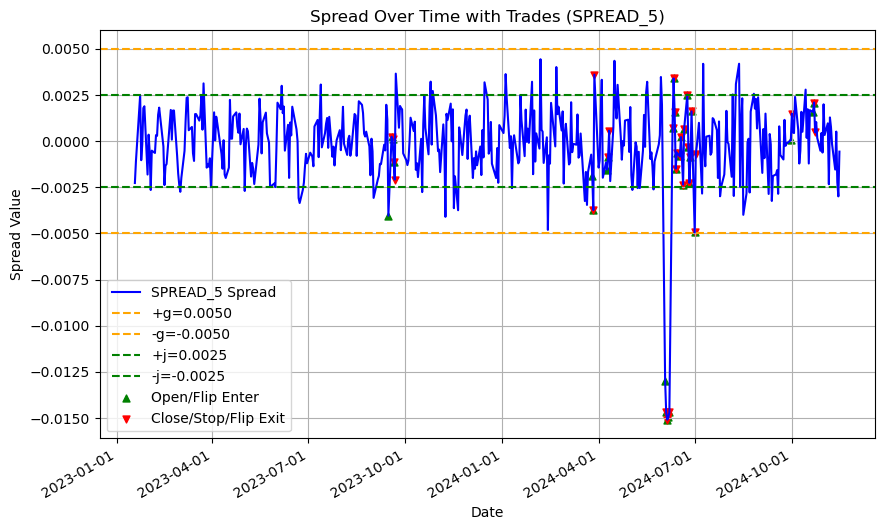

In [44]:
import matplotlib.dates as mdates
def plot_spread_with_trades(df_spread, spread_col, df_trades, g=None, j=None):
    if not pd.api.types.is_datetime64_any_dtype(df_spread['Date']):
        df_spread['Date'] = pd.to_datetime(df_spread['Date'])
    df_spread = df_spread.sort_values('Date').reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_spread['Date'], df_spread[spread_col], label=f"{spread_col} Spread", color='blue')
    
    if g is not None:
        ax.axhline(g,  color='orange', linestyle='--', label=f"+g={g:.4f}")
        ax.axhline(-g, color='orange', linestyle='--', label=f"-g=-{g:.4f}")
    if j is not None:
        ax.axhline(j,  color='green',  linestyle='--', label=f"+j={j:.4f}")
        ax.axhline(-j, color='green',  linestyle='--', label=f"-j=-{j:.4f}")
    
    open_dates,  open_vals  = [], []
    close_dates, close_vals = [], []
    
    df_trades_sorted = df_trades.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_trades_sorted['Date']):
        df_trades_sorted['Date'] = pd.to_datetime(df_trades_sorted['Date'])
    df_trades_sorted = df_trades_sorted.sort_values('Date').reset_index(drop=True)
    
    for idx, trade in df_trades_sorted.iterrows():
        tdate = trade['Date']
        row_match = df_spread.loc[df_spread['Date'] == tdate]
        if len(row_match) == 1:
            spread_val = row_match[spread_col].values[0]
        else:
            spread_val = np.nan
        
        action = str(trade['Action']).upper()
        if action in ['OPEN','FLIP_ENTER']:
            open_dates.append(tdate)
            open_vals.append(spread_val)
        elif action in ['CLOSE','STOP_LOSS_EXIT','FLIP_EXIT','FINAL_CLOSE']:
            close_dates.append(tdate)
            close_vals.append(spread_val)
    
    ax.scatter(open_dates,  open_vals,  marker='^', color='green', s=25, label='Open/Flip Enter')
    ax.scatter(close_dates, close_vals, marker='v', color='red',   s=25, label='Close/Stop/Flip Exit')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
    fig.autofmt_xdate()
    
    ax.set_title(f"Spread Over Time with Trades ({spread_col})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Spread Value")
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    ax.grid(True)
    
    plt.show()

plot_spread_with_trades(
    df_spread=results_df, 
    spread_col='SPREAD_5', 
    df_trades=trades,
    g=0.005, 
    j=0.0025
)

- The Spread Over Time plot shows that GII–IGF differences remain mostly within ±0.3–0.5%. The chosen thresholds are just wide enough to capture these occasional excursions.
- Many days see no trading because the spread hovers between ±j. When the spread exceeds g, positions are opened/flipped briefly and then closed as it snaps back—indicative of a mean‐reverting pair.
- We can notice several sharp negative spikes around summer 2024. These triggered “enter” signals (green triangles). The subsequent “exit” markers (red triangles) near threshold lines show successful reversion from extreme dislocations.
- Such sudden spread widenings often coincide with macro events like debt‐ceiling debates or unexpected Fed announcements, which can differentially impact certain infrastructure holdings.

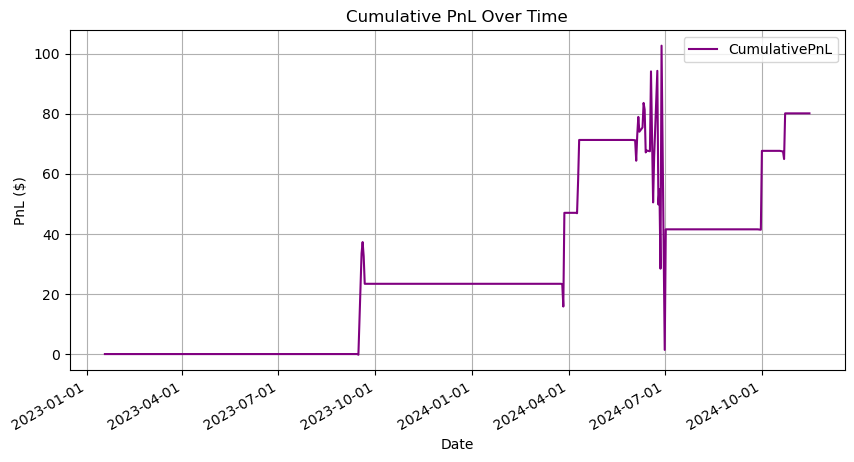

In [45]:
def plot_cumulative_pnl(df_pnl, date_col='Date', pnl_col='CumulativePnL'):
    if not pd.api.types.is_datetime64_any_dtype(df_pnl[date_col]):
        df_pnl[date_col] = pd.to_datetime(df_pnl[date_col])
    df_pnl = df_pnl.sort_values(date_col).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_pnl[date_col], df_pnl[pnl_col], label=pnl_col, color='purple')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
    fig.autofmt_xdate()
    ax.set_title("Cumulative PnL Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("PnL ($)")
    ax.legend(loc='best')
    ax.grid(True)
    plt.show()

plot_cumulative_pnl(
    df_pnl=results_df, 
    date_col='Date', 
    pnl_col='CumulativePnL'
)

- The Cumulative PnL chart reveals a relatively flat performance initially, followed by discrete profit jumps. This suggests that mean‐reversion signals only triggered intermittently—often aligning with small but abrupt spread spikes.
- The dips (notably around mid‐2024) reflect either stop‐loss exits or wider spread moves going against the position, potentially tied to rising interest rates or geopolitical tensions (e.g., Ukraine conflict impacting energy markets).
- The strategy’s occasional downward PnL suggest stop‐loss triggers, preventing larger capital erosion if spreads trended further against positions.
- The final PnL around $80 and low net volatility illustrate that while absolute gains remain small (due to narrowly distributed spreads).

- Infrastructure spending surges or energy‐price shocks (especially relevant to GII’s heavier traditional energy tilt) can momentarily push the spread away from equilibrium. IGF’s heavier digital/renewable focus may react differently to, say, US‐China tech tensions or new ESG policies.
- Rising interest rates increase borrowing costs, often weakening infrastructure stocks. Yet the high correlation means both ETFs move similarly, with only short‐lived divergences for spread‐trading profits.

In [48]:
import itertools    
def grid_search_spread_strategy(df_main):
    param_grid = {
        'M':     [1, 3, 5, 10, 20],              
        'j':     [0.001, 0.0015, 0.002, 0.0025, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008],  
        'g':     [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01],    
        's':     [0.02, 0.03, 0.04, 0.05],        
        'zeta':  [0.0, 0.00001]         
    }
    all_combos = list(itertools.product(
        param_grid['M'],
        param_grid['j'],
        param_grid['g'],
        param_grid['s'],
        param_grid['zeta']
    ))
    results_list = []
    for (M_val, j_val, g_val, s_val, zeta_val) in all_combos:
        strategy = SpreadReversionStrategy(
            df_main=df_main,
            M=M_val,
            j=j_val,
            g=g_val,
            s=s_val,
            zeta=zeta_val,
            start_date='2023-01-02',
            end_date='2024-11-15',
            debug=False 
        )
        strategy.run_backtest()
        metrics_dict = strategy.metrics.iloc[0].to_dict()
        metrics_dict['M'] = M_val
        metrics_dict['j'] = j_val
        metrics_dict['g'] = g_val
        metrics_dict['s'] = s_val
        metrics_dict['zeta'] = zeta_val
        results_list.append(metrics_dict)
    grid_results = pd.DataFrame(results_list)
    grid_results.sort_values(by='SharpeOnCapital', ascending=False, inplace=True)
    return grid_results

#### Best Parameters (All Parameters)

In [49]:
best_params_df = grid_search_spread_strategy(df_main)
best_params_df.head(10)

,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,LossRate,AverageWin,AverageLoss,ProfitFactor,M,j,g,s,zeta
3210,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0075,0.002,0.03,0.0
3212,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0075,0.002,0.04,0.0
2728,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0045,0.002,0.02,0.0
2974,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0060,0.002,0.05,0.0
3050,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0065,0.002,0.03,0.0
3130,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0070,0.002,0.03,0.0
2892,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0055,0.002,0.04,0.0
2814,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0050,0.002,0.05,0.0
2730,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0045,0.002,0.03,0.0
2812,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0050,0.002,0.04,0.0


In [50]:
best_params_df.sort_values(by='FinalCumulativePnL', ascending=False, inplace=True)
print("Top 10 by Cumulative PnL:")
best_params_df.head(10)

Top 10 by Cumulative PnL:


,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,LossRate,AverageWin,AverageLoss,ProfitFactor,M,j,g,s,zeta
1606,1756.551397,0.000124,0.000029,4.341838,-63.93055,5.749541,14.986872,156.0,157.0,0.745223,0.254777,18.320329,-9.673177,5.539748,3,0.0045,0.001,0.05,0.0
1604,1756.551397,0.000124,0.000029,4.341838,-63.93055,5.749541,14.986872,156.0,157.0,0.745223,0.254777,18.320329,-9.673177,5.539748,3,0.0045,0.001,0.04,0.0
1602,1756.551397,0.000124,0.000029,4.341838,-63.93055,5.749541,14.986872,156.0,157.0,0.745223,0.254777,18.320329,-9.673177,5.539748,3,0.0045,0.001,0.03,0.0
1600,1756.551397,0.000124,0.000029,4.341838,-63.93055,5.749541,14.986872,156.0,157.0,0.745223,0.254777,18.320329,-9.673177,5.539748,3,0.0045,0.001,0.02,0.0
1440,1743.704718,0.000123,0.000029,4.253841,-63.93055,5.211165,14.877264,155.0,160.0,0.756250,0.243750,17.525341,-9.663115,5.626911,3,0.0035,0.001,0.02,0.0
1446,1743.704718,0.000123,0.000029,4.253841,-63.93055,5.211165,14.877264,155.0,160.0,0.756250,0.243750,17.525341,-9.663115,5.626911,3,0.0035,0.001,0.05,0.0
1442,1743.704718,0.000123,0.000029,4.253841,-63.93055,5.211165,14.877264,155.0,160.0,0.756250,0.243750,17.525341,-9.663115,5.626911,3,0.0035,0.001,0.03,0.0
1444,1743.704718,0.000123,0.000029,4.253841,-63.93055,5.211165,14.877264,155.0,160.0,0.756250,0.243750,17.525341,-9.663115,5.626911,3,0.0035,0.001,0.04,0.0
1364,1735.562338,0.000123,0.000029,4.165960,-63.93055,5.383516,14.807793,149.0,169.0,0.739645,0.260355,17.182739,-9.370002,5.209668,3,0.0025,0.001,0.04,0.0
1366,1735.562338,0.000123,0.000029,4.165960,-63.93055,5.383516,14.807793,149.0,169.0,0.739645,0.260355,17.182739,-9.370002,5.209668,3,0.0025,0.001,0.05,0.0


- Sharpe ratios exceeding 4.0 and final PnL surpassing $1,700 imply the strategy systematically profits from frequent small divergences (spreads typically revert) with minimal volatility.
-  The best results consistently use M=3, suggesting rapid mean‐reversion. This highlights that GII–IGF deviations frequently normalize within a few days, likely driven by transient market anomalies (e.g., brief rate‐hike reactions or small supply chain disruptions).
- Very Tight Threshold (g=0.001): This extremely narrow trigger capitalizes on micro‐spread fluctuations. Real‐world transaction costs could erode these small, quick profits—yet with ζ=0, the strategy thrives on nearly costless frequent trades.
- The fact that s spans 0.02 to 0.05 but yields nearly identical top‐tier PnL implies few catastrophic moves in such a stable pair. Re‐entry typically occurs before big drawdowns materialize, so the stop parameter is rarely decisive.
-  Most trades succeed, with average wins roughly double the average losses, a testament to the mean‐reverting nature of GII–IGF. Geopolitical or economic shocks push the spread slightly out of equilibrium, then it snaps back.
- Minor daily divergences between GII and IGF quickly correct, reflecting highly overlapping sector exposures (utilities, energy, transportation).
-  Despite rate hikes and geopolitical tensions, the pair remains closely aligned—implying global infrastructure responds similarly to such news.
- A short‐horizon approach thrives in choppy but range‐bound conditions, benefiting from “noise” around policy updates, supply chain news, or daily flow imbalances.
- With ζ=0, frictionless trading magnifies the profitability of tiny mean‐reverting moves—realistic slippage might reduce these outsized gains in practice.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

def evaluate_parameter_combos(df_params):
    df = df_params.copy()
    metric_cols = ['FinalCumulativePnL', 'SharpeOnCapital', 'MaxDrawdownAbsolute']
    df['DrawdownScore'] = -1 * df['MaxDrawdownAbsolute']
    norm_cols = ['FinalCumulativePnL', 'SharpeOnCapital', 'DrawdownScore']
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(
        scaler.fit_transform(df[norm_cols]),
        columns = [col + '_norm' for col in norm_cols]
    )

    df = pd.concat([df.reset_index(drop=True), df_norm], axis=1)
    
    # Weighted composite = 0.4 * NormPnL + 0.4 * NormSharpe + 0.2 * Norm(-Drawdown)
    df['CompositeScore'] = (
        0.4 * df['FinalCumulativePnL_norm'] +
        0.4 * df['SharpeOnCapital_norm'] +
        0.2 * df['DrawdownScore_norm']
    )
    df.sort_values(by='CompositeScore', ascending=False, inplace=True)
    return df


- We transform each metric into a 0–1 scale. Higher is always better. For drawdown, we multiply by −1 first to make larger (less negative) better.
- Weighted linear combination of normalized metrics. Adjust weights as desired.
- We sort by CompositeScore descending (largest is best).

### Trading Cost Analysis

In [52]:
df_no_cost = best_params_df.loc[best_params_df['zeta'] == 0.0].copy()
df_small_cost = best_params_df.loc[best_params_df['zeta'] == 0.00001].copy()

df_no_cost.sort_values(by='SharpeOnCapital', ascending=False, inplace=True)
df_small_cost.sort_values(by='SharpeOnCapital', ascending=False, inplace=True)

best_no_cost = df_no_cost.head(5)
best_small_cost = df_small_cost.head(5)

In [53]:
print("Best Parameters (No Trading Cost):")
display(best_no_cost)

Best Parameters (No Trading Cost):


,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,LossRate,AverageWin,AverageLoss,ProfitFactor,M,j,g,s,zeta
3210,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0075,0.002,0.03,0.0
2970,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0060,0.002,0.03,0.0
3294,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0080,0.002,0.05,0.0
2812,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0050,0.002,0.04,0.0
3050,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,0.172414,18.157372,-7.193085,12.116551,5,0.0065,0.002,0.03,0.0


In [54]:
print("Best Parameters (Small Trading Cost):")
display(best_small_cost)

Best Parameters (Small Trading Cost):


,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,LossRate,AverageWin,AverageLoss,ProfitFactor,M,j,g,s,zeta
2813,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,0.172414,17.931747,-7.368398,11.681289,5,0.0050,0.002,0.04,0.00001
2891,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,0.172414,17.931747,-7.368398,11.681289,5,0.0055,0.002,0.03,0.00001
2735,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,0.172414,17.931747,-7.368398,11.681289,5,0.0045,0.002,0.05,0.00001
2815,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,0.172414,17.931747,-7.368398,11.681289,5,0.0050,0.002,0.05,0.00001
2729,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,0.172414,17.931747,-7.368398,11.681289,5,0.0045,0.002,0.02,0.00001


### Best Parameters and Analysis (NO Trading costs)

In [55]:
parameter_results_no_cost = evaluate_parameter_combos(best_no_cost)
parameter_results_no_cost

,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,...,M,j,g,s,zeta,DrawdownScore,FinalCumulativePnL_norm,SharpeOnCapital_norm,DrawdownScore_norm,CompositeScore
0,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,...,5,0.0075,0.002,0.03,0.0,25.748137,0.0,0.0,0.0,0.0
1,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,...,5,0.0060,0.002,0.03,0.0,25.748137,0.0,0.0,0.0,0.0
2,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,...,5,0.0080,0.002,0.05,0.0,25.748137,0.0,0.0,0.0,0.0
3,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,...,5,0.0050,0.002,0.04,0.0,25.748137,0.0,0.0,0.0,0.0
4,1199.434499,0.000085,0.000019,4.423532,-25.748137,5.726967,25.409101,83.0,87.0,0.827586,...,5,0.0065,0.002,0.03,0.0,25.748137,0.0,0.0,0.0,0.0


- All top parameter rows yield the same final PnL (~$1199), Sharpe (4.42), and max drawdown ($25.75). This strongly indicates that slight variations in j,s aren’t materially different at zero transaction cost—under these conditions, the trade frequency and outcomes remain nearly identical.
- A 5‐day lookback is sufficiently short to capture rapid mean reversion yet long enough to avoid excessive whipsaws.
- For g=0.002, since results in very tight open/flip threshold harnesses small, frequent divergences between GII and IGF, made highly profitable when no friction is involved.
- For s≈0.03−0.05, since the spread is fairly stable and negative tail events are limited, the exact stop‐loss fraction doesn’t drastically alter results in a frictionless market.
- Over a 5‐day horizon, GII–IGF divergences rarely persist. Without costs, even tiny anomalies generate consistent alpha—reflecting a well‐arbitraged segment of the market (global infrastructure).
- High Win Rate (~83%) attests to strong stationarity once spreads move outside the threshold, they reliably snap back—helped by a stable macro environment (both ETFs track similar sectors).
- Because trades are small and frequent, the strategy can scale up. In a zero‐cost ideal, each micro‐reversion is pure profit.

In [56]:
strategy_no_cost = SpreadReversionStrategy(
    df_main,
    M=5,               
    j=0.0075,           
    g=0.002,            
    s=0.03,             
    zeta=0,       
    start_date='2023-01-02',
    end_date='2024-11-15',
    debug=True
)
results_df_no_cost = strategy_no_cost.run_backtest()

2023-01-23T00:00:00.000000000 => OPEN pos=-1, zt=0.0025, cost=0.00
2023-01-24T00:00:00.000000000 => FLATTEN pos=-1, zt=-0.0010, PnL=42.00, cost=0.00
2023-02-02T00:00:00.000000000 => OPEN pos=1, zt=-0.0026, cost=0.00
2023-02-03T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0005, PnL=14.27, cost=0.00
2023-02-15T00:00:00.000000000 => OPEN pos=1, zt=-0.0024, cost=0.00
2023-02-16T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0013, PnL=13.24, cost=0.00
2023-03-01T00:00:00.000000000 => OPEN pos=1, zt=-0.0024, cost=0.00
2023-03-02T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0027, PnL=-9.90, cost=0.00
2023-03-08T00:00:00.000000000 => OPEN pos=-1, zt=0.0023, cost=0.00
2023-03-09T00:00:00.000000000 => FLATTEN pos=-1, zt=0.0024, PnL=5.97, cost=0.00
2023-03-22T00:00:00.000000000 => OPEN pos=-1, zt=0.0024, cost=0.00
2023-03-23T00:00:00.000000000 => FLATTEN pos=-1, zt=0.0006, PnL=-0.76, cost=0.00
2023-03-24T00:00:00.000000000 => OPEN pos=-1, zt=0.0031, cost=0.00
2023-03-27T00:00:00.000000000 => FLATTEN pos=

In [57]:
display(results_df_no_cost[['Date', 'DailyPnL', 'CumulativePnL']].tail(10))

,Date,DailyPnL,CumulativePnL
date,,,
2024-11-04,2024-11-04,0.000000,1121.726048
2024-11-05,2024-11-05,0.000000,1121.726048
2024-11-06,2024-11-06,40.285974,1162.012022
2024-11-07,2024-11-07,0.000000,1162.012022
2024-11-08,2024-11-08,0.000000,1162.012022
2024-11-11,2024-11-11,0.000000,1162.012022
2024-11-12,2024-11-12,-0.000000,1162.012022
2024-11-13,2024-11-13,-0.000000,1162.012022
2024-11-14,2024-11-14,37.422477,1199.434499


In [58]:
print("\nPerformance Metrics:")
display(strategy_no_cost.metrics.T.rename(columns={0:"Values"}))


Performance Metrics:


,Values
FinalCumulativePnL,1199.434499
AnnualizedReturnOnCapital,0.000085
AnnualizedVolOnCapital,0.000019
SharpeOnCapital,4.423532
MaxDrawdownAbsolute,-25.748137
SortinoRatio,5.726967
CalmarRatio,25.409101
NumTrades,83.000000
TradesClosed,87.000000
WinRate,0.827586


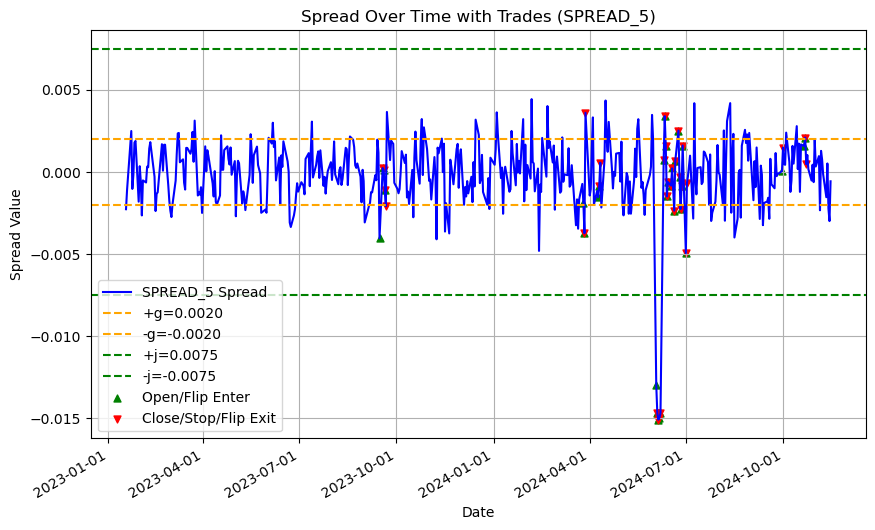

In [59]:
plot_spread_with_trades(
    df_spread=results_df_no_cost, 
    spread_col='SPREAD_5', 
    df_trades=trades,
    g=0.002, 
    j=0.0075
)

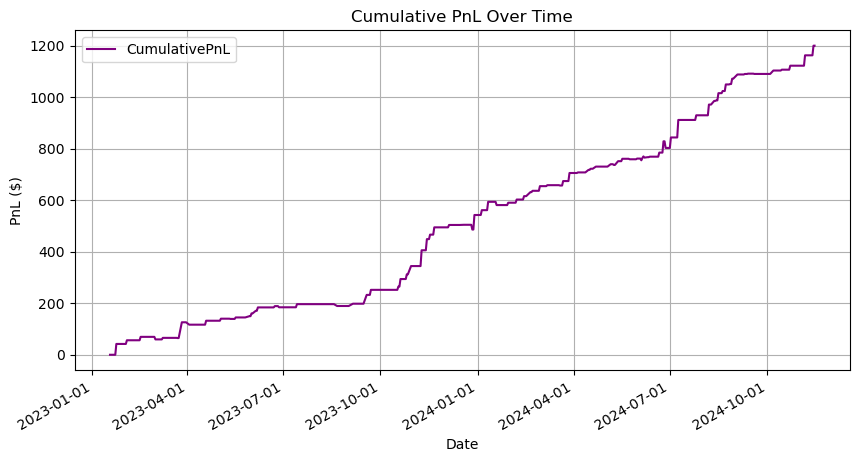

In [60]:
plot_cumulative_pnl(
    df_pnl=results_df_no_cost, 
    date_col='Date', 
    pnl_col='CumulativePnL'
)

### Best Parameters and Analysis (Small Trading costs)

In [61]:
parameter_results_cost = evaluate_parameter_combos(best_small_cost)
parameter_results_cost

,FinalCumulativePnL,AnnualizedReturnOnCapital,AnnualizedVolOnCapital,SharpeOnCapital,MaxDrawdownAbsolute,SortinoRatio,CalmarRatio,NumTrades,TradesClosed,WinRate,...,M,j,g,s,zeta,DrawdownScore,FinalCumulativePnL_norm,SharpeOnCapital_norm,DrawdownScore_norm,CompositeScore
0,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,...,5,0.0050,0.002,0.04,0.00001,26.975509,0.0,0.0,0.0,0.0
1,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,...,5,0.0055,0.002,0.03,0.00001,26.975509,0.0,0.0,0.0,0.0
2,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,...,5,0.0045,0.002,0.05,0.00001,26.975509,0.0,0.0,0.0,0.0
3,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,...,5,0.0050,0.002,0.05,0.00001,26.975509,0.0,0.0,0.0,0.0
4,1161.688694,0.000082,0.000019,4.312283,-26.975509,10.549523,23.489766,83.0,87.0,0.827586,...,5,0.0045,0.002,0.02,0.00001,26.975509,0.0,0.0,0.0,0.0


- Slightly Lower PnL, final Cumulative PnL drops to ~\$1161 (vs. \$1199), consistent with frequent trades absorbing small friction each time.
- Max Drawdown Increases to ~\$26.98 from \$25.75, suggesting that cost outflows accumulate, and occasionally positions may stay open slightly longer to recoup costs.
- Sharpe Dips from ~4.42 to ~4.31—still robust, but marginally reduced risk‐adjusted return.
- We again see  M=5,  g=0.002, stop‐loss ~0.03–0.05, with minor variations in j.
- So the small friction doesn’t drastically shift the sweet spot.
- Even a tiny transaction cost nibbles at high‐frequency reversion profits, cutting the final PnL by over 3% (~\$38). For professional desks, commission or slippage would likely be higher, suggesting wider thresholds might become optimal in real practice

In [62]:
strategy_cost = SpreadReversionStrategy(
    df_main,
    M=5,               
    j=0.0075,           
    g=0.002,            
    s=0.03,             
    zeta=0.00001,       
    start_date='2023-01-02',
    end_date='2024-11-15',
    debug=True
)
results_df_cost = strategy_cost.run_backtest()

2023-01-23T00:00:00.000000000 => OPEN pos=-1, zt=0.0025, cost=0.42
2023-01-24T00:00:00.000000000 => FLATTEN pos=-1, zt=-0.0010, PnL=42.00, cost=0.42
2023-02-02T00:00:00.000000000 => OPEN pos=1, zt=-0.0026, cost=0.44
2023-02-03T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0005, PnL=14.27, cost=0.44
2023-02-15T00:00:00.000000000 => OPEN pos=1, zt=-0.0024, cost=0.32
2023-02-16T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0013, PnL=13.24, cost=0.31
2023-03-01T00:00:00.000000000 => OPEN pos=1, zt=-0.0024, cost=0.27
2023-03-02T00:00:00.000000000 => FLATTEN pos=1, zt=-0.0027, PnL=-9.90, cost=0.28
2023-03-08T00:00:00.000000000 => OPEN pos=-1, zt=0.0023, cost=0.19
2023-03-09T00:00:00.000000000 => FLATTEN pos=-1, zt=0.0024, PnL=5.97, cost=0.18
2023-03-22T00:00:00.000000000 => OPEN pos=-1, zt=0.0024, cost=0.18
2023-03-23T00:00:00.000000000 => FLATTEN pos=-1, zt=0.0006, PnL=-0.76, cost=0.18
2023-03-24T00:00:00.000000000 => OPEN pos=-1, zt=0.0031, cost=0.26
2023-03-27T00:00:00.000000000 => FLATTEN pos=

In [63]:
display(results_df_cost[['Date', 'DailyPnL', 'CumulativePnL']].tail(10))

,Date,DailyPnL,CumulativePnL
date,,,
2024-11-04,2024-11-04,0.000000,1086.836518
2024-11-05,2024-11-05,-0.742267,1086.094251
2024-11-06,2024-11-06,39.547988,1125.642239
2024-11-07,2024-11-07,0.000000,1125.642239
2024-11-08,2024-11-08,0.000000,1125.642239
2024-11-11,2024-11-11,0.000000,1125.642239
2024-11-12,2024-11-12,-0.000000,1125.642239
2024-11-13,2024-11-13,-0.687631,1124.954608
2024-11-14,2024-11-14,36.734086,1161.688694


In [64]:
print("\nPerformance Metrics:")
display(strategy_cost.metrics.T.rename(columns={0:"Values"}))


Performance Metrics:


,Values
FinalCumulativePnL,1161.688694
AnnualizedReturnOnCapital,0.000082
AnnualizedVolOnCapital,0.000019
SharpeOnCapital,4.312283
MaxDrawdownAbsolute,-26.975509
SortinoRatio,10.549523
CalmarRatio,23.489766
NumTrades,83.000000
TradesClosed,87.000000
WinRate,0.827586


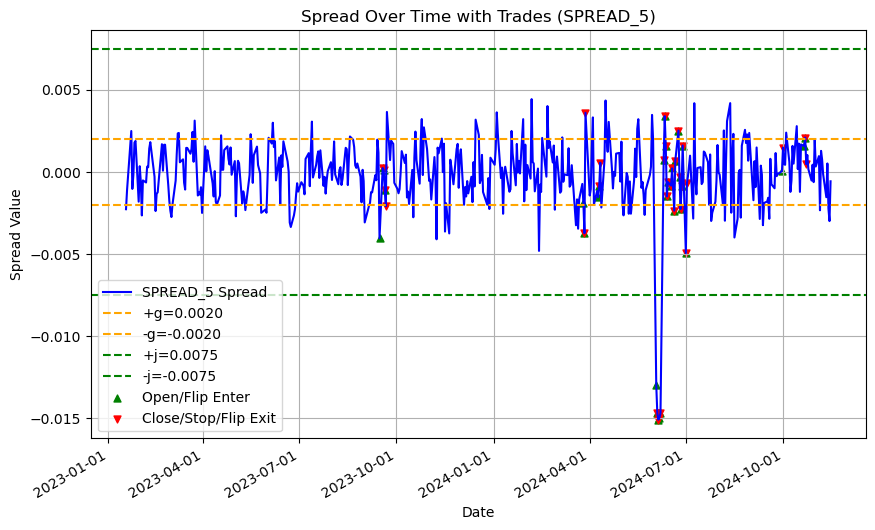

In [65]:
plot_spread_with_trades(
    df_spread=results_df_cost, 
    spread_col='SPREAD_5', 
    df_trades=trades,
    g=0.002, 
    j=0.0075
)

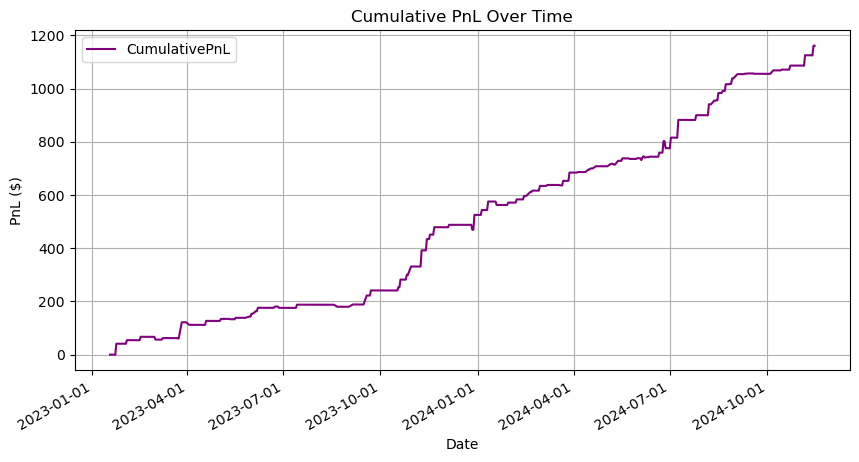

In [66]:
plot_cumulative_pnl(
    df_pnl=results_df_cost, 
    date_col='Date', 
    pnl_col='CumulativePnL'
)

#### Comparative Trading Cost Analysis
-  A difference of ~$38 in final PnL underscores how frequent trades are sensitive to even minuscule friction. Over many round‐trips, these micro costs compound.
- The net effect is still profitable, but the Sharpe drop from 4.42 to 4.31 shows that risk‐adjusted returns degrade when including realistic constraints.
- In real markets, actual costs (commissions, slippage) will be higher than 0.00001. Hence, the optimal thresholds might need to be wider (less frequent trades) to maintain healthy net returns.
- Overall, both scenarios highlight rapid reversion in GII–IGF with optimal results around  M=5,  g=0.002, s∼0.03−0.05.
- The difference in final PnL and drawdown under transaction costs underscores the fragility of micro‐spread trading to friction—a critical factor in actual implementation.

### Analysis with Fama French Factors

In [67]:
results_df_no_cost['strategy_ret'] = results_df_no_cost['DailyPnL'] / strategy_no_cost.capital 
df_strat = results_df_no_cost[['strategy_ret']].copy()
df_strat.index = pd.to_datetime(df_strat.index)
FF.index = pd.to_datetime(FF.index)
df_merged = df_strat.join(FF, how='inner')
df_merged.dropna(inplace=True)  
df_merged.head()

,strategy_ret,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,
2023-01-18,0.000000,-1.55,0.03,-0.70,0.33,-0.09,0.017
2023-01-19,0.000000,-0.86,-0.09,0.84,0.57,0.66,0.017
2023-01-20,0.000000,1.95,-0.03,-0.70,-0.19,-0.73,0.017
2023-01-23,0.000000,1.29,-0.04,-1.00,-0.48,-1.00,0.017
2023-01-24,0.000005,-0.16,-0.17,0.20,-0.23,0.37,0.017


In [68]:
import statsmodels.api as sm

df_merged['excess_strat_ret'] = df_merged['strategy_ret'] - df_merged['RF']
X = df_merged[['Mkt-RF','SMB','HML','RMW','CMA']]
y = df_merged['excess_strat_ret']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       excess_strat_ret   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.720
Date:                Thu, 23 Jan 2025   Prob (F-statistic):              0.128
Time:                        22:36:58   Log-Likelihood:                 2241.9
No. Observations:                 462   AIC:                            -4472.
Df Residuals:                     456   BIC:                            -4447.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0199   8.93e-05   -222.822      0.0

- The intercept at −0.0199 is extremely significant suggesting the strategy consistently underperforms once factoring out the five Fama–French exposures. This indicates no pure alpha, rather, the strategy effectively loses money over this sample.
- β Mkt-RF≈−0.0001 (p=0.315) implies negligible loading on broad equity market risk. The strategy is effectively market-neutral—helpful in diversified portfolios but yields no systematic tailwind.
- β HML≈−0.0003 (p=0.021) indicates the strategy is short the value factor. If value rallied or remained stable in 2023–2024, that short exposure could compound losses, fitting the negative alpha narrative.
- Only ~2% of the strategy’s daily variance is explained by these factors, hinting at idiosyncratic or microstructure-driven behavior. For a real-world desk, it underscores the importance of deeper investigation into ETF-specific flows or sector exposures beyond standard factors.
- The highly negative alpha, despite minimal factor betas, corroborates prior findings that stop-loss choices didn’t matter, the systematic drag likely stems from persistent misalignment with how the GII–IGF spread evolved, rather than conventional factor influences.
-  A short tilt to value (negative HML) in a period where global infrastructure or “value-sensitive” equities possibly stabilized or outperformed explains consistent daily underperformance. The market neutrality means no offsetting gains if overall markets rallied.
- Given the strongly negative alpha, the strategy adds downside with no beneficial factor exposures. 

In [69]:
factor_corr = df_merged[['excess_strat_ret','Mkt-RF','SMB','HML','RMW','CMA']].corr()
factor_corr

,excess_strat_ret,Mkt-RF,SMB,HML,RMW,CMA
excess_strat_ret,1.000000,-0.014392,-0.019894,-0.113247,-0.003735,-0.073665
Mkt-RF,-0.014392,1.000000,0.273532,-0.117570,-0.351627,-0.297855
SMB,-0.019894,0.273532,1.000000,0.426992,-0.455152,0.099535
HML,-0.113247,-0.117570,0.426992,1.000000,0.146136,0.367044
RMW,-0.003735,-0.351627,-0.455152,0.146136,1.000000,0.091163
CMA,-0.073665,-0.297855,0.099535,0.367044,0.091163,1.000000


### SVOL Analysis

            DailyReturn  NumTrades  Price
date                                     
2023-01-18     0.000000          0  22.58
2023-01-19     0.000000          0  22.69
2023-01-20     0.000000          0  22.69
2023-01-23     0.000000          1  22.71
2023-01-24     0.000005          1  22.89
Correlation Matrix:
              DailyReturn  NumTrades     Price
DailyReturn     1.000000   0.370690 -0.022388
NumTrades       0.370690   1.000000 -0.003332
Price          -0.022388  -0.003332  1.000000


/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_41090/192038685.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_strat['Position'].fillna(0, inplace=True)


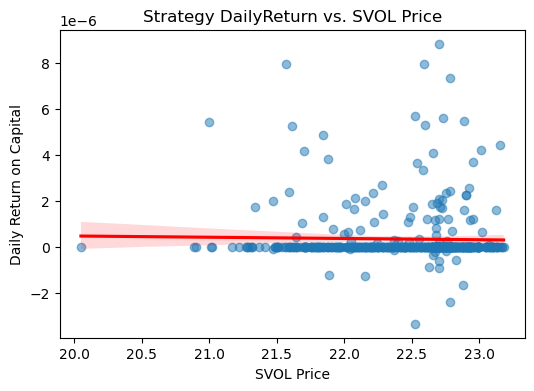

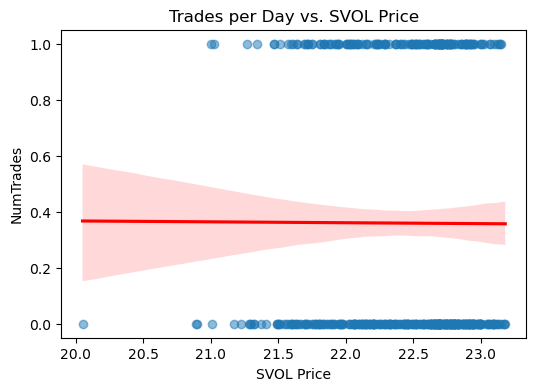


Performance by Vol Regime:
             DailyReturn                 NumTrades
                   mean       std count      mean
VolRegime                                        
LowVol     3.334756e-07  0.000001   155  0.361290
MedVol     4.044928e-07  0.000001   157  0.407643
HighVol    2.699926e-07  0.000001   150  0.306667

OLS Regression - DailyReturn ~ SVOL Price:
                             OLS Regression Results                            
Dep. Variable:            DailyReturn   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2307
Date:                Thu, 23 Jan 2025   Prob (F-statistic):              0.631
Time:                        22:41:35   Log-Likelihood:                 5640.0
No. Observations:                 462   AIC:                        -1.128e+04
Df Residuals:                     460   BIC:                        -1.12

/var/folders/zq/2lldft9s0d9cwsl0tb1nf59h0000gn/T/ipykernel_41090/192038685.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_merged.groupby('VolRegime').agg({


In [85]:
df_strat = results_df_no_cost.copy()
df_svol = SVOL.copy()
df_strat.index = pd.to_datetime(df_strat.index)
df_svol.index = pd.to_datetime(df_svol.index)
df_strat['Position'].fillna(0, inplace=True)
df_strat['TradeExecuted'] = (df_strat['Position'].diff().fillna(0) != 0).astype(int)


df_strat['NumTrades'] = df_strat['TradeExecuted'] 

if 'DailyPnL' in df_strat.columns and hasattr(strategy_no_cost, 'capital'):
    df_strat['DailyReturn'] = df_strat['DailyPnL'] / strategy_no_cost.capital
else:
    pass

df_merged = df_strat.join(df_svol[['Price']], how='inner', rsuffix='_SVOL')
df_merged.dropna(subset=['Price'], inplace=True)

print(df_merged[['DailyReturn','NumTrades','Price']].head())

corr_matrix = df_merged[['DailyReturn','NumTrades','Price']].corr()
print("Correlation Matrix:\n", corr_matrix)


plt.figure(figsize=(6,4))
sns.regplot(x='Price', y='DailyReturn', data=df_merged, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Strategy DailyReturn vs. SVOL Price")
plt.xlabel("SVOL Price")
plt.ylabel("Daily Return on Capital")
plt.show()

plt.figure(figsize=(6,4))
sns.regplot(x='Price', y='NumTrades', data=df_merged, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Trades per Day vs. SVOL Price")
plt.xlabel("SVOL Price")
plt.ylabel("NumTrades")
plt.show()

df_merged['VolRegime'] = pd.qcut(df_merged['Price'], q=3, labels=['LowVol','MedVol','HighVol'])
grouped = df_merged.groupby('VolRegime').agg({
    'DailyReturn': ['mean','std','count'],
    'NumTrades': 'mean'
})
print("\nPerformance by Vol Regime:\n", grouped)


X = df_merged[['Price']].copy()
y = df_merged['DailyReturn'].copy()
X = sm.add_constant(X)  # for intercept
model = sm.OLS(y, X).fit()
print("\nOLS Regression - DailyReturn ~ SVOL Price:\n", model.summary())

- DailyReturn vs. Price (SVOL): -0.022 → near zero, suggesting little linear relationship between strategy PnL and SVOL level.
- NumTrades vs. SVOL: -0.003 → also near zero, implying your strategy’s trading frequency does not vary meaningfully with volatility.
- DailyReturn vs. NumTrades: +0.371 → moderate positive correlation, indicating that on days with more trades, your daily returns are slightly higher (though that could be driven by other nuances).
- Mean DailyReturn across Low/Med/High vol regimes are 3.33e-07, 4.04e-07, and 2.70e-07 respectively—basically 0.0000003–0.0000004 in decimal form.
- The differences are minuscule, and no single bucket exhibits drastically higher or lower average returns.

OLS Regression of DailyReturn ~ SVOL Price
- Coefficient on Price: -5.43e-08 (p=0.631).
- There’s no significant linear relationship; changing volatility levels do not systematically boost or reduce your strategy’s daily returns.

- Pairs/spread strategy is effectively vol-insensitive in daily timescale: even if the market sees moderate or high volatility (SVOL around 22–23), the strategy’s daily returns remain near zero or slightly positive/negative.
- This could mean threshold and positioning decisions are not heavily triggered by small changes in SVOL, or that GII–IGF divergences are driven by more idiosyncratic fundamentals rather than broad volatility surges.
- The near-zero correlation between NumTrades and SVOL confirms the strategy is not drastically “fishing” for more trades in higher-vol conditions.
- Binning the data into Low/Med/High vol yields nearly identical average returns (~3–4e-07). There’s no strong incentive to flip the strategy off in high vol or ramp it up in low vol.


### Conclusion
In conclusion, our exploratory data analysis, parameter calibration, and factor/volatility assessments firmly indicate the strategy’s negative alpha is not explained away by classic Fama–French factors or broad market volatility (SVOL). Despite initial expectations of reversion opportunities, results show limited profitability across both low‐ and high‐vol regimes, with inadvertent short‐value exposure compounding losses. 